<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<center><img src = "https://github.com/Jangrae/img/blob/master/bike2.png?raw=true" width=800/></center>

# 학습 목표

- 일정 시간 간격으로 배치된 데이터들 시계열 데이터(Time Series Data)라고 합니다.
- 시계열 데이터를 다양한 방법으로 탐색하는 방법을 학습합니다.
- 머신러닝 모델을 만들어 2시간 뒤 자전거 수요량을 예측해 봅니다.

# 1. 환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [3]:
# 시각화 폰트 사이즈 설정
plt.rc('font', size=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', linewidth=0.3)

In [5]:
# 데이터 불러오기
path = 'https://bit.ly/BikeFile'
bike= pd.read_csv(path)

# 확인
bike.head()

,DateTime,Temperature,Humidity,WindSpeed,Seasons,Holiday,Count
0,2017-12-01 0:00,-5.2,37,2.2,Winter,No Holiday,254
1,2017-12-01 1:00,-5.5,38,0.8,Winter,No Holiday,204
2,2017-12-01 2:00,-6.0,39,1.0,Winter,No Holiday,173
3,2017-12-01 3:00,-6.2,40,0.9,Winter,No Holiday,107
4,2017-12-01 4:00,-6.0,36,2.3,Winter,No Holiday,78


- 날짜와 시간 정보에서 필요한 정보(년, 월, 일 등)를 추출하기 쉽게 datetime 형으로 변환합니다.

In [7]:
# 확인
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateTime     8760 non-null   object 
 1   Temperature  8760 non-null   float64
 2   Humidity     8760 non-null   int64  
 3   WindSpeed    8760 non-null   float64
 4   Seasons      8760 non-null   object 
 5   Holiday      8760 non-null   object 
 6   Count        8760 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 479.2+ KB


In [9]:
# datetime 변환
bike['DateTime'] = pd.to_datetime(bike['DateTime'])

# 확인
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     8760 non-null   datetime64[ns]
 1   Temperature  8760 non-null   float64       
 2   Humidity     8760 non-null   int64         
 3   WindSpeed    8760 non-null   float64       
 4   Seasons      8760 non-null   object        
 5   Holiday      8760 non-null   object        
 6   Count        8760 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 479.2+ KB


- 별도로 제공되는 평가용 데이터가 없으므로, 뒷 부분의 일부를 평가용 데이터로 분리해 둡니다.

In [11]:
# 평가용 데이터 분리
data_test = bike.loc[bike['DateTime'] >= '2018-11-01', :].copy()
data = bike.loc[bike['DateTime'] < '2018-11-01', :].copy()

# 확인
print('Train Data:', data.shape)
print('Test Data:', data_test.shape)

Train Data: (8040, 7)
Test Data: (720, 7)


# **2. 데이터 이해**

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.
- 시계열 데이터인 경우 데이터 패턴을 시각적으로 확인해야 합니다.

## **(1) 데이터 확인**

- 데이터에 대한 기본 정보를 확인합니다.

**1) 상위/하위 데이터 확인**

In [13]:
# 상위 데이터
data.head()

,DateTime,Temperature,Humidity,WindSpeed,Seasons,Holiday,Count
0,2017-12-01 00:00:00,-5.2,37,2.2,Winter,No Holiday,254
1,2017-12-01 01:00:00,-5.5,38,0.8,Winter,No Holiday,204
2,2017-12-01 02:00:00,-6.0,39,1.0,Winter,No Holiday,173
3,2017-12-01 03:00:00,-6.2,40,0.9,Winter,No Holiday,107
4,2017-12-01 04:00:00,-6.0,36,2.3,Winter,No Holiday,78


**데이터 설명**

- DateTime: year-month-day hh:mi:ss
- Temperature: 온도(섭씨)
- Humidity: 습도(%)
- WindSpeed: 풍속(m/s)
- Seasons: 계절(Spring, Summer, Autumn, Winter)
- Holiday: 휴일 여부(Holiday / No Holiday)
- Count: 시간대별 수요량

In [15]:
# 하위 데이터
data.tail()

,DateTime,Temperature,Humidity,WindSpeed,Seasons,Holiday,Count
8035,2018-10-31 19:00:00,8.4,53,1.0,Autumn,No Holiday,1507
8036,2018-10-31 20:00:00,7.6,59,0.7,Autumn,No Holiday,1176
8037,2018-10-31 21:00:00,7.6,59,3.0,Autumn,No Holiday,1069
8038,2018-10-31 22:00:00,6.8,58,2.2,Autumn,No Holiday,1088
8039,2018-10-31 23:00:00,6.4,60,1.8,Autumn,No Holiday,798


In [17]:
# 날짜, 시간 범위 확인
print(data['DateTime'].min(), '~', data['DateTime'].max())

2017-12-01 00:00:00 ~ 2018-10-31 23:00:00


In [19]:
# 기술 통계
data.describe()

,DateTime,Temperature,Humidity,WindSpeed,Count
count,8040,8040.000000,8040.000000,8040.000000,8040.000000
mean,2018-05-17 11:30:00,13.337301,58.271020,1.755336,709.775995
min,2017-12-01 00:00:00,-17.800000,0.000000,0.000000,0.000000
25%,2018-02-22 17:45:00,3.200000,43.000000,1.000000,191.000000
50%,2018-05-17 11:30:00,15.350000,57.000000,1.600000,485.000000
75%,2018-08-09 05:15:00,23.200000,74.000000,2.400000,1080.500000
max,2018-10-31 23:00:00,39.400000,98.000000,7.400000,3556.000000
std,NaN,12.292018,20.340492,1.046664,657.320605


## (2) 범줏값 확인

- 범줏값 분포를 확인합니다.

**1) 계절(Seasons)**

In [21]:
# Seasons
print(data['Seasons'].value_counts())
print('-' * 25)
print(data['Seasons'].value_counts(normalize=True))

Seasons
Spring    2208
Summer    2208
Winter    2160
Autumn    1464
Name: count, dtype: int64
-------------------------
Seasons
Spring    0.274627
Summer    0.274627
Winter    0.268657
Autumn    0.182090
Name: proportion, dtype: float64


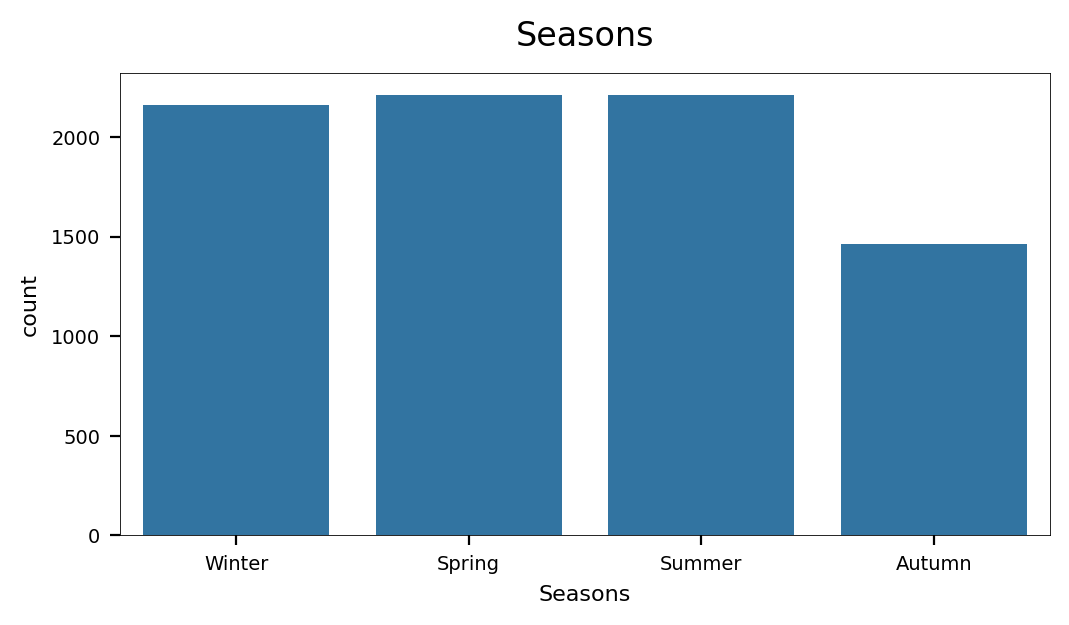

In [23]:
# Season 비율 시각화
plt.figure(figsize=(6, 3))
sns.countplot(x=data['Seasons'])
plt.title('Seasons', size=12, pad=10)
plt.show()

**2) 휴일(Holiday)**

In [25]:
# Holiday
print(data['Holiday'].value_counts())
print('-' * 25)
print(data['Holiday'].value_counts(normalize=True))

Holiday
No Holiday    7608
Holiday        432
Name: count, dtype: int64
-------------------------
Holiday
No Holiday    0.946269
Holiday       0.053731
Name: proportion, dtype: float64


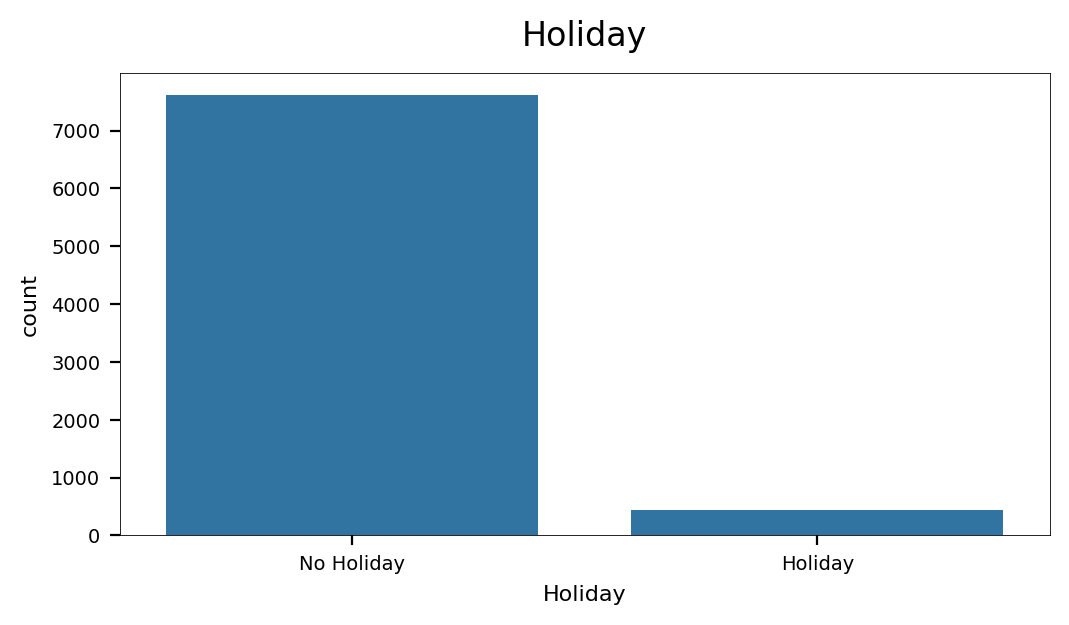

In [27]:
# Holiday 비율 시각화
plt.figure(figsize=(6, 3))
sns.countplot(x=data['Holiday'])
plt.title('Holiday', size=12, pad=10)
plt.show()

## (3) 연속값 확인

- 연속값의 변화 추이를 확인합니다.

In [30]:
# 함수 만들기
def show_trend(col, start, end='9999-12-31'):
    temp = data.loc[data['DateTime'].between(start, end)]
    plt.figure(figsize=(10, 2))
    plt.plot('DateTime', col, data=temp, linewidth=0.8)
    plt.title(col, size=12, pad=10)
    plt.tight_layout()
    plt.show()

**1) 수요량(Count)**

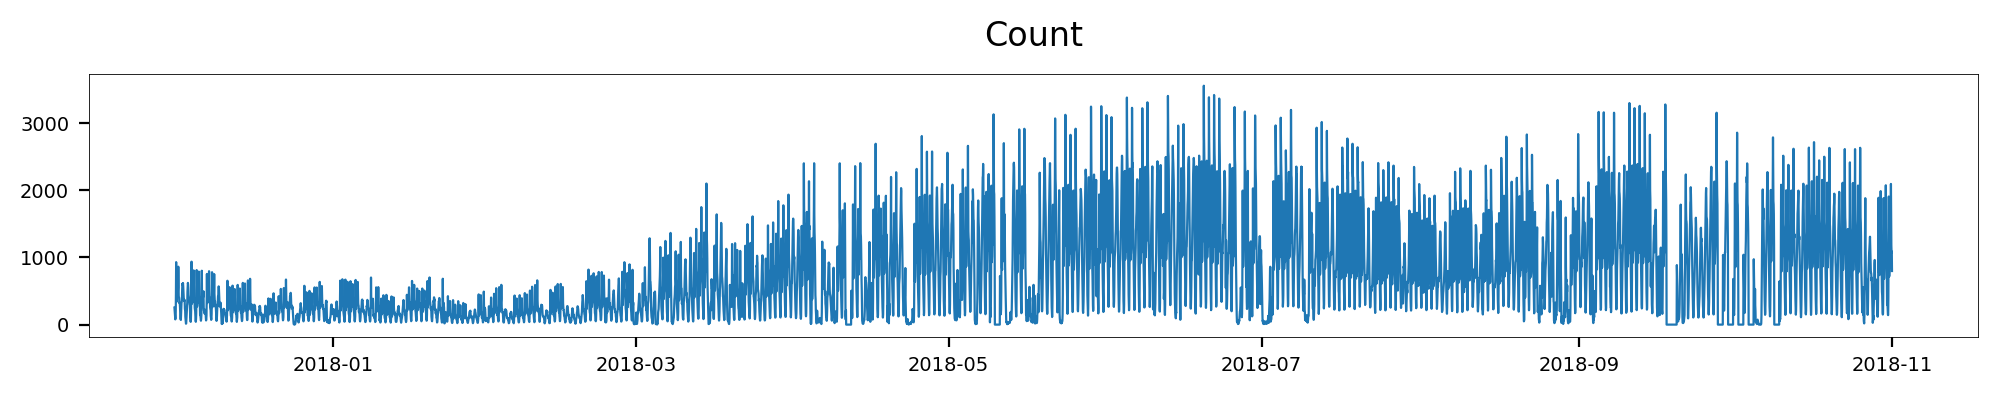

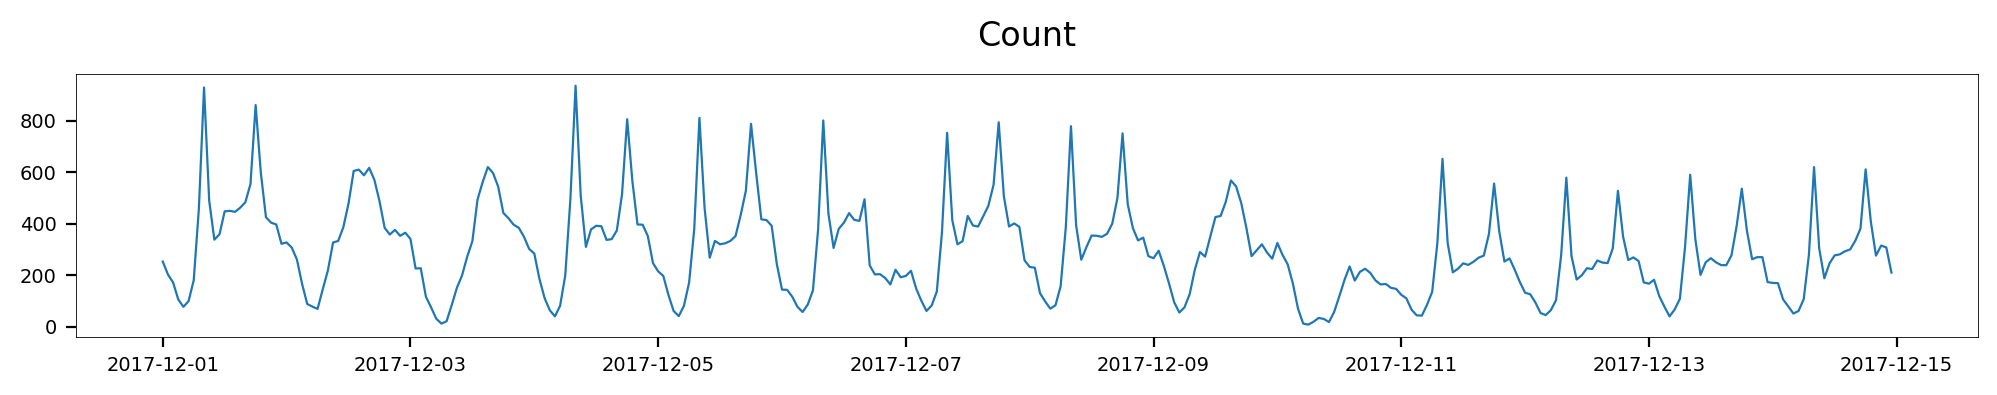

In [32]:
# 수요량
show_trend('Count', '2017-12-01 00:00:00')
show_trend('Count', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

**2) 기온(Temperature)**

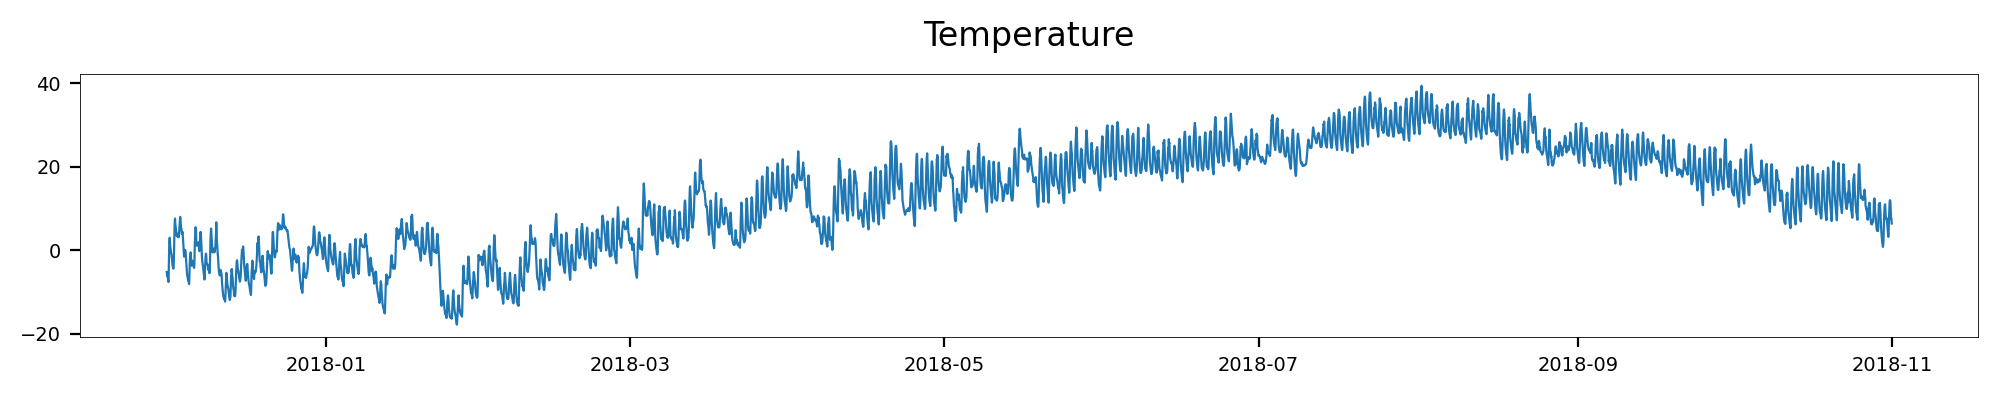

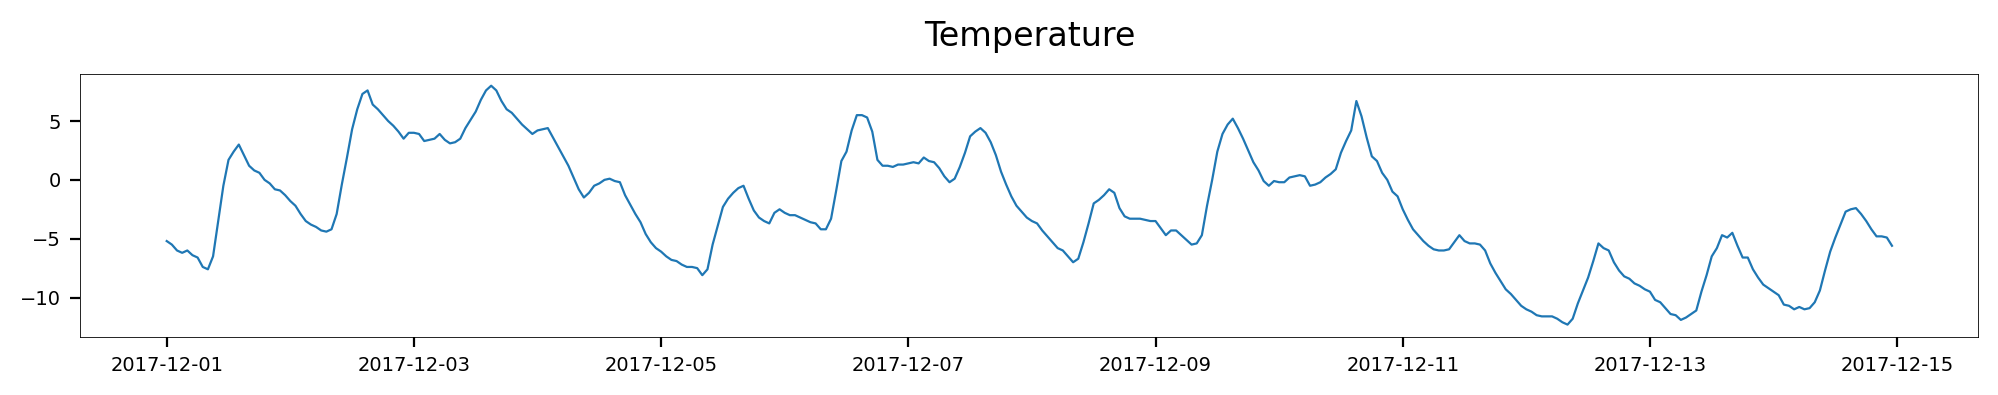

In [34]:
# 기온
show_trend('Temperature', '2017-12-01 00:00:00')
show_trend('Temperature', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

**3) 습도(Humidity)**

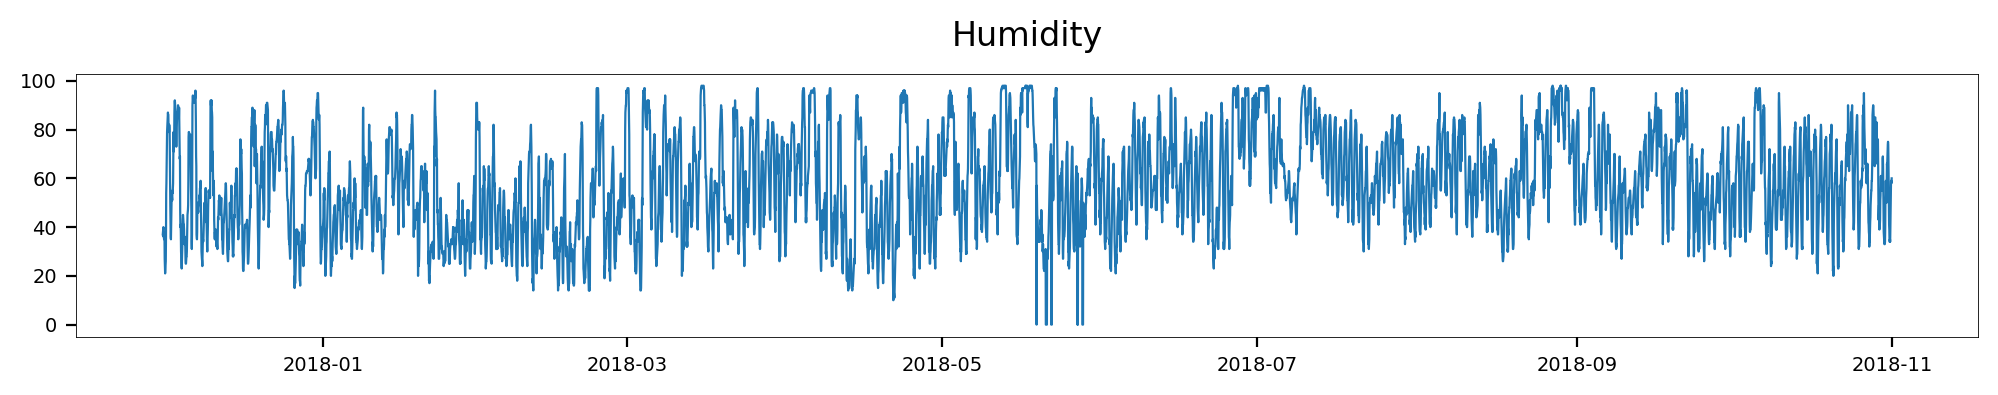

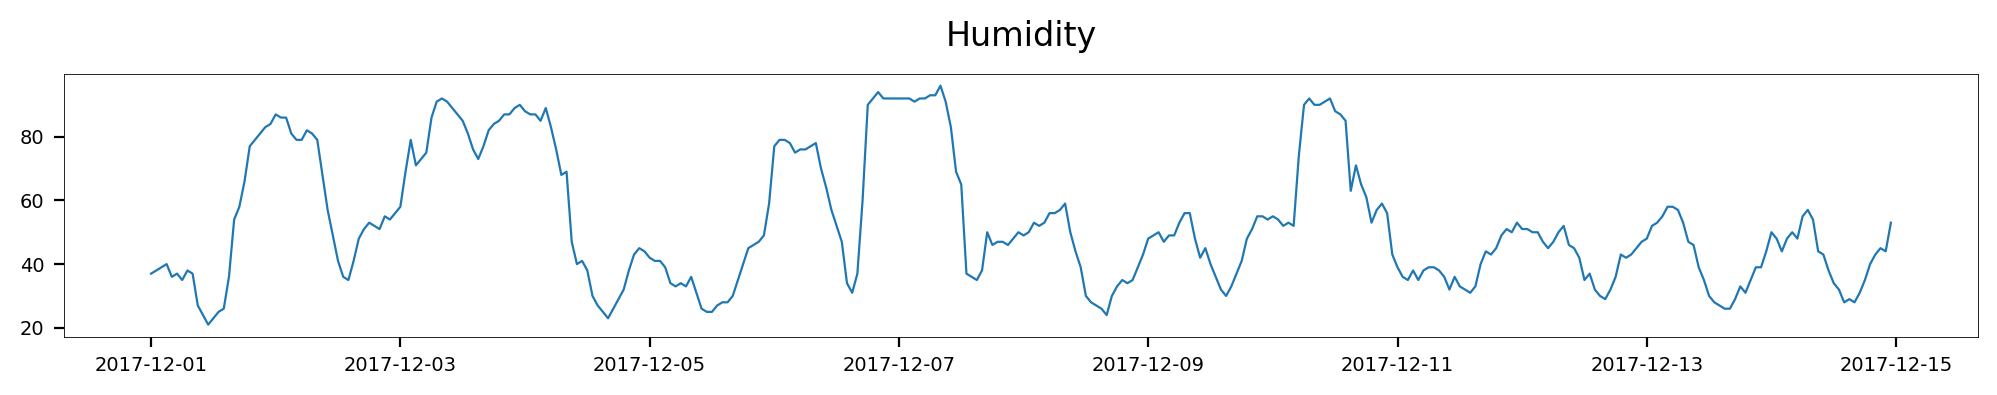

In [37]:
# 습도
show_trend('Humidity', '2017-12-01 00:00:00')
show_trend('Humidity', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

**4) 풍속(WindSpeed)**

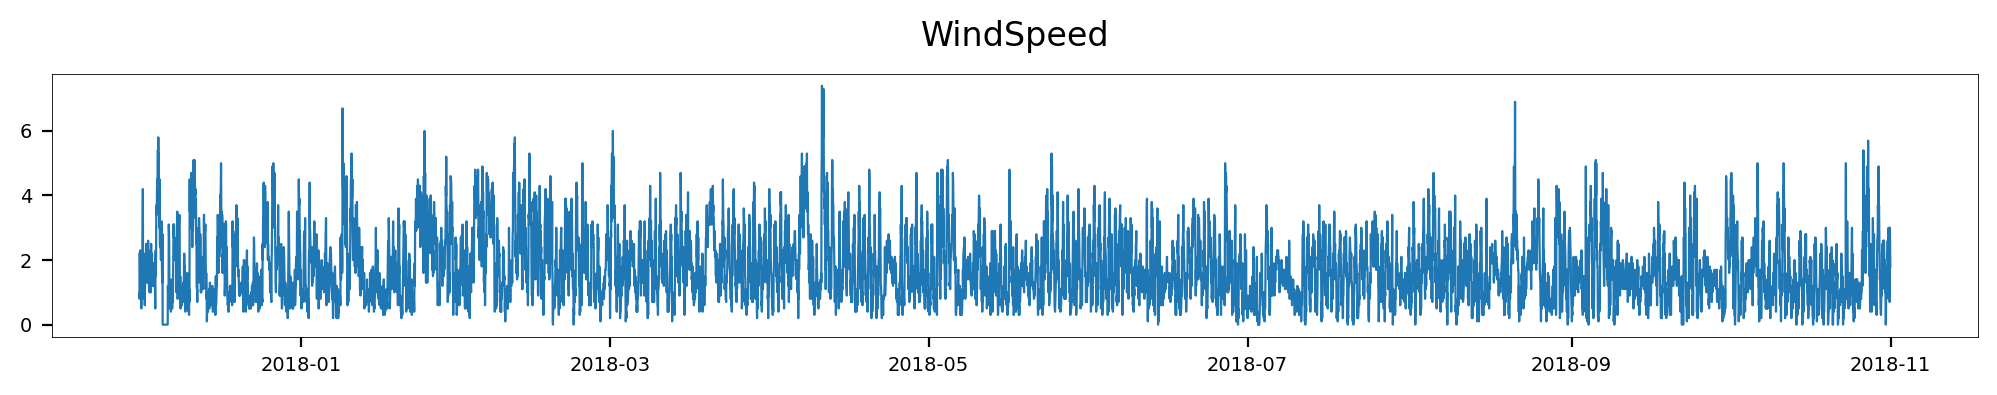

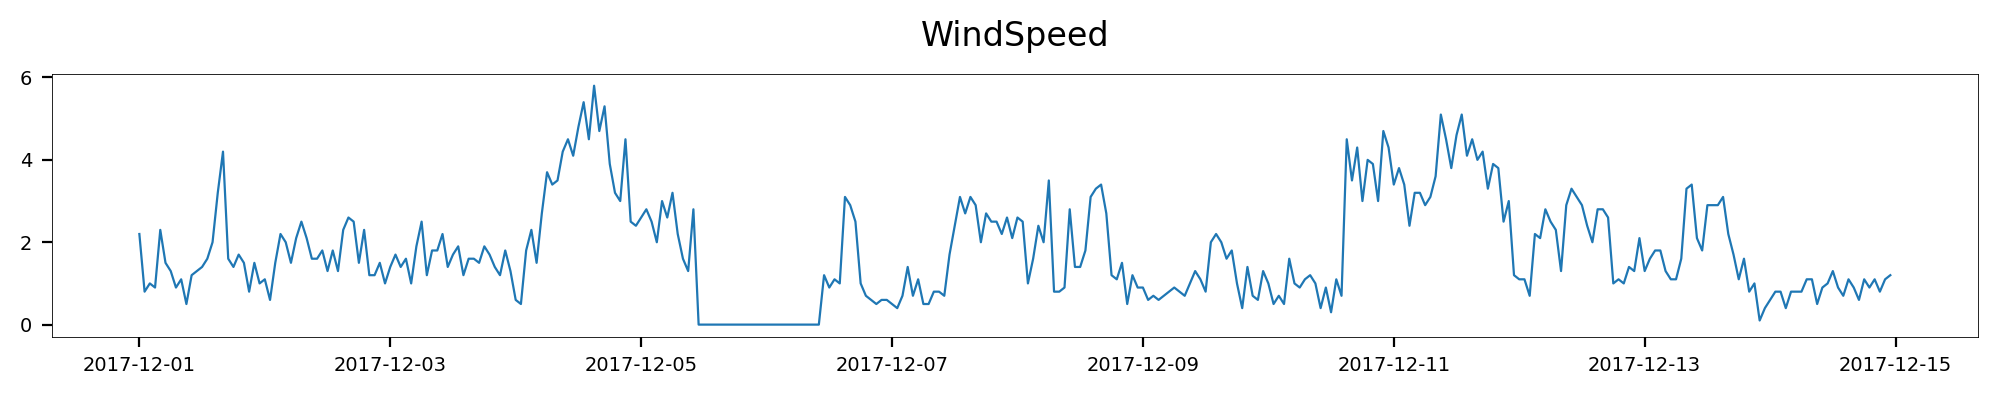

In [40]:
# 풍속
show_trend('WindSpeed', '2017-12-01 00:00:00')
show_trend('WindSpeed', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

# 3. 지연 특성 추가를 위한 분석

- 지연 특성을 추가하기 전에 수행해야 할 탐색 과정은 데이터의 시간적 패턴과 관계를 이해하는 데 초점을 맞추어야 합니다.
- 이러한 과정을 통해 모델에 어떤 지연 특성이 유용할지, 그리고 어느 시간 범위의 지연이 예측에 도움이 될지 판단할 수 있습니다.
- 아래는 지연 특성을 추가하기 전에 고려해볼 수 있는 몇 가지 탐색 과정입니다:

## (1) 시계열 데이터 시각화

- 수요량의 변화와 다른 변수값의 변화를 서로 비교합니다.
- 반복해서 사용되는 구문은 함수로 만들어 사용하는 것이 좋습니다.

In [42]:
# 함수 만들기
def show_trend_count(col, start, end='9999-12-31'):
    temp = data.loc[data['DateTime'].between(start, end)]
    plt.figure(figsize=(10, 4))
    plt.subplot(2, 1, 1)
    plt.plot('DateTime', 'Count', data=temp, linewidth=0.8)
    plt.title('Count', size=12, pad=10)
    plt.subplot(2, 1, 2)
    plt.plot('DateTime', col, data=temp, linewidth=0.8)
    plt.title(col, size=12, pad=10)
    plt.tight_layout()
    plt.show()

**1) 기온 & 수요량**

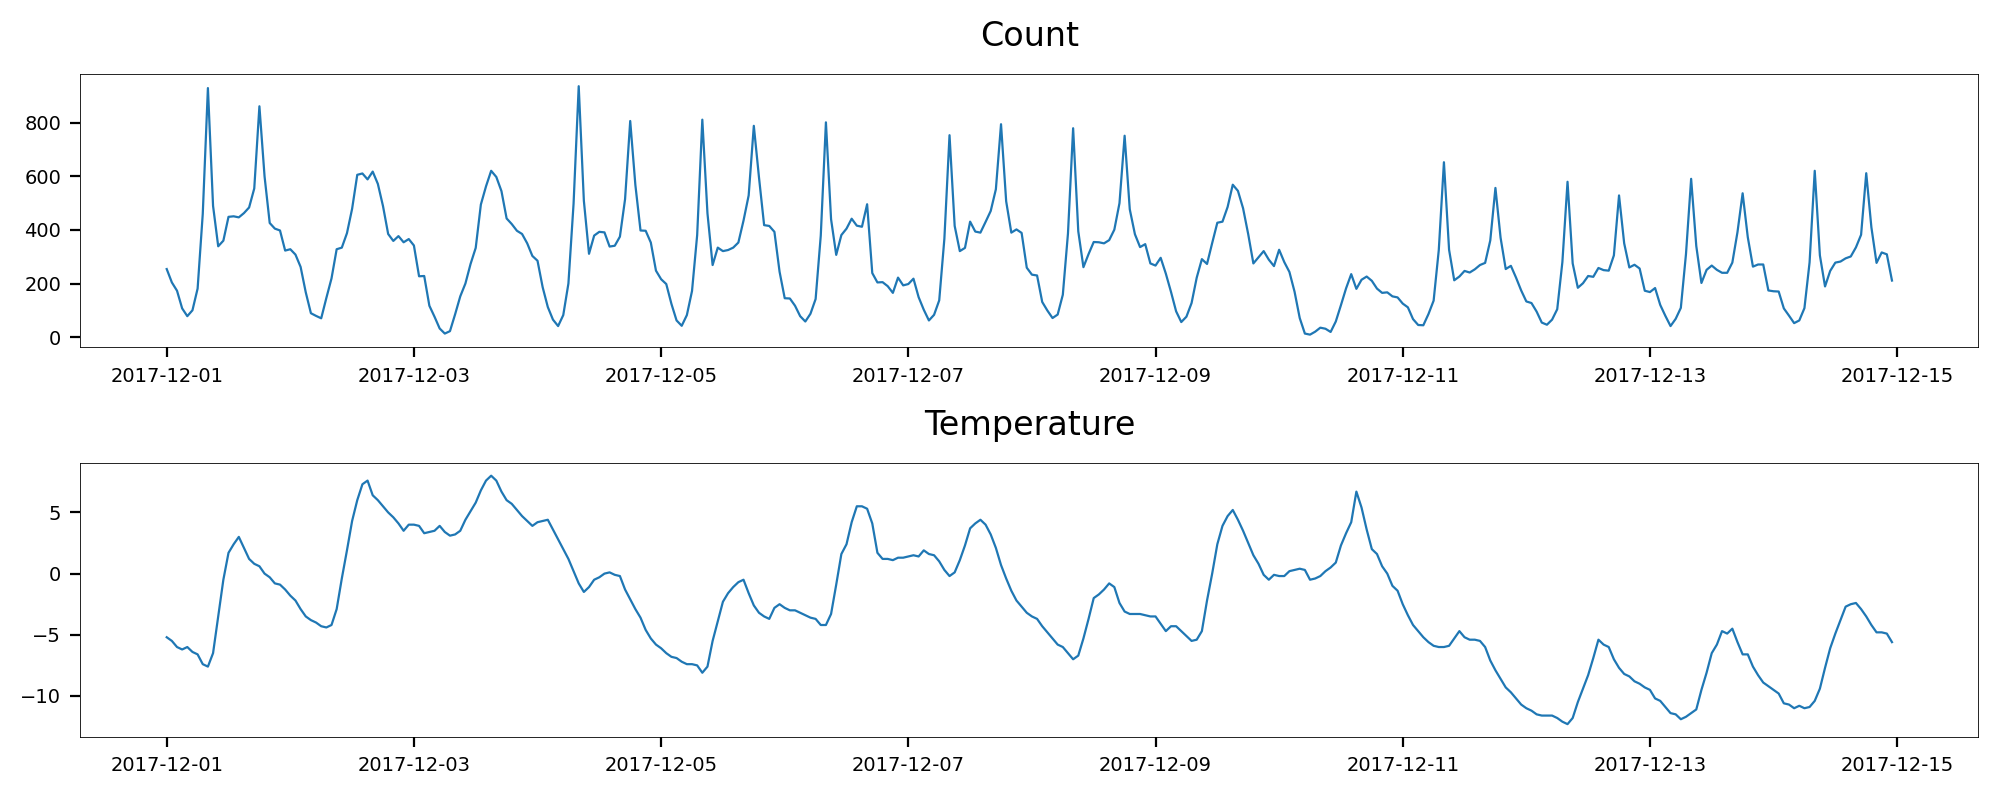

In [45]:
# 기온 & 수요량
show_trend_count('Temperature', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

**2) 습도 & 수요량**

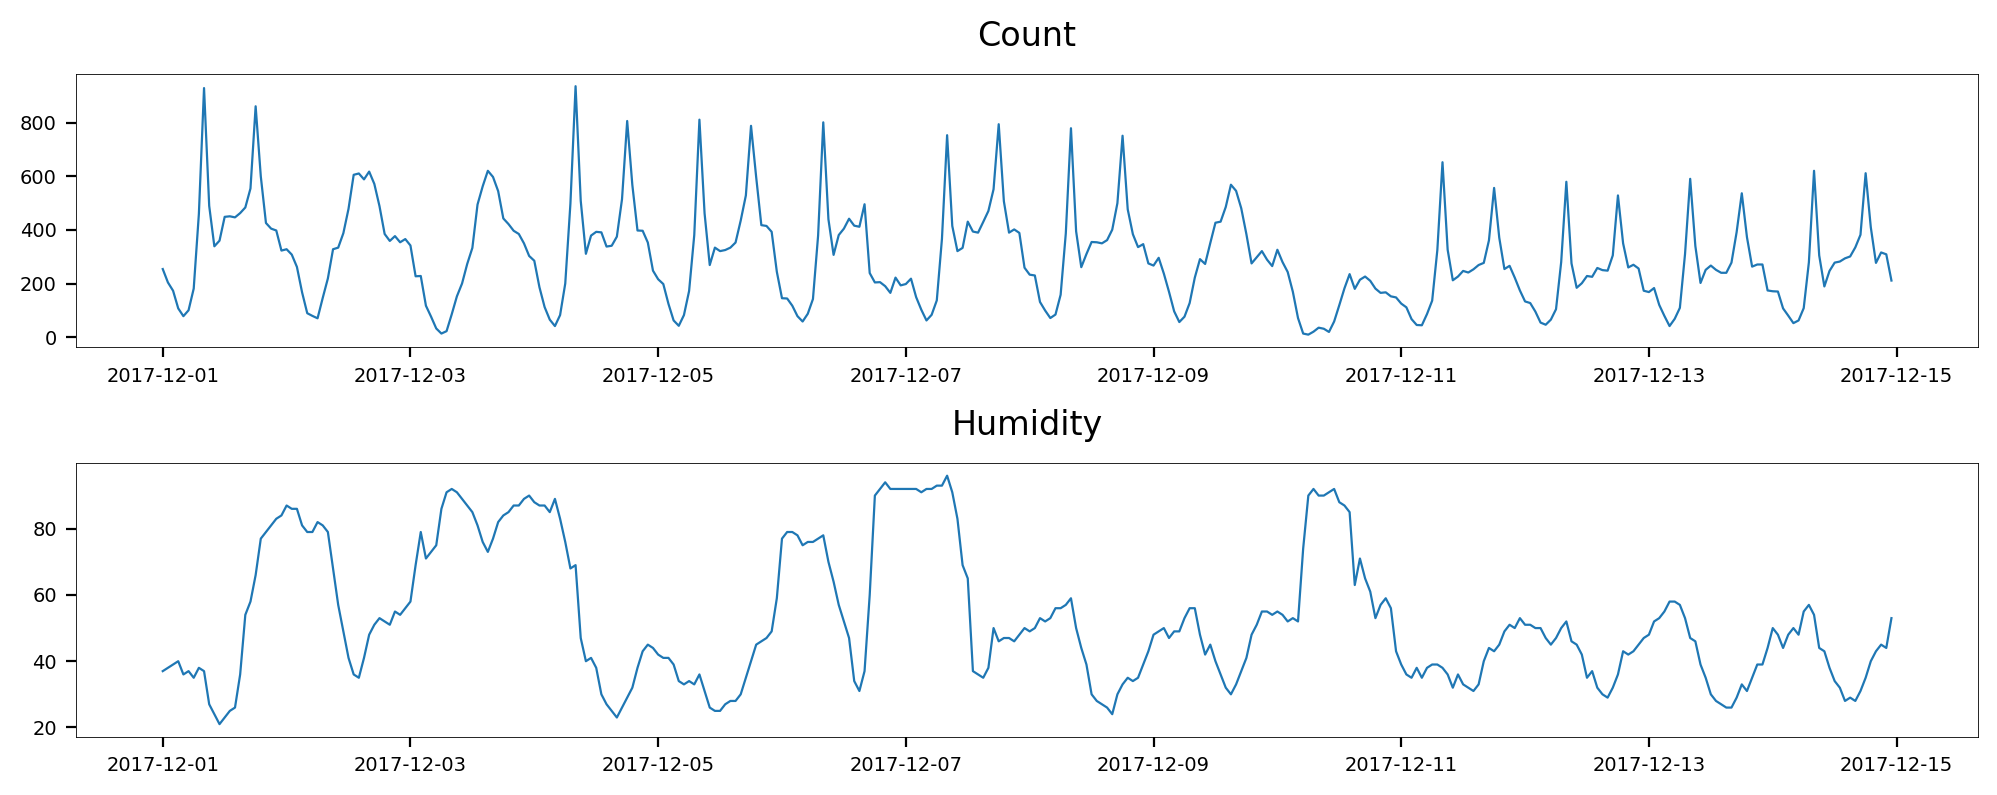

In [47]:
# 습도 & 수요량
show_trend_count('Humidity', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

**3) 풍속 & 수요량**

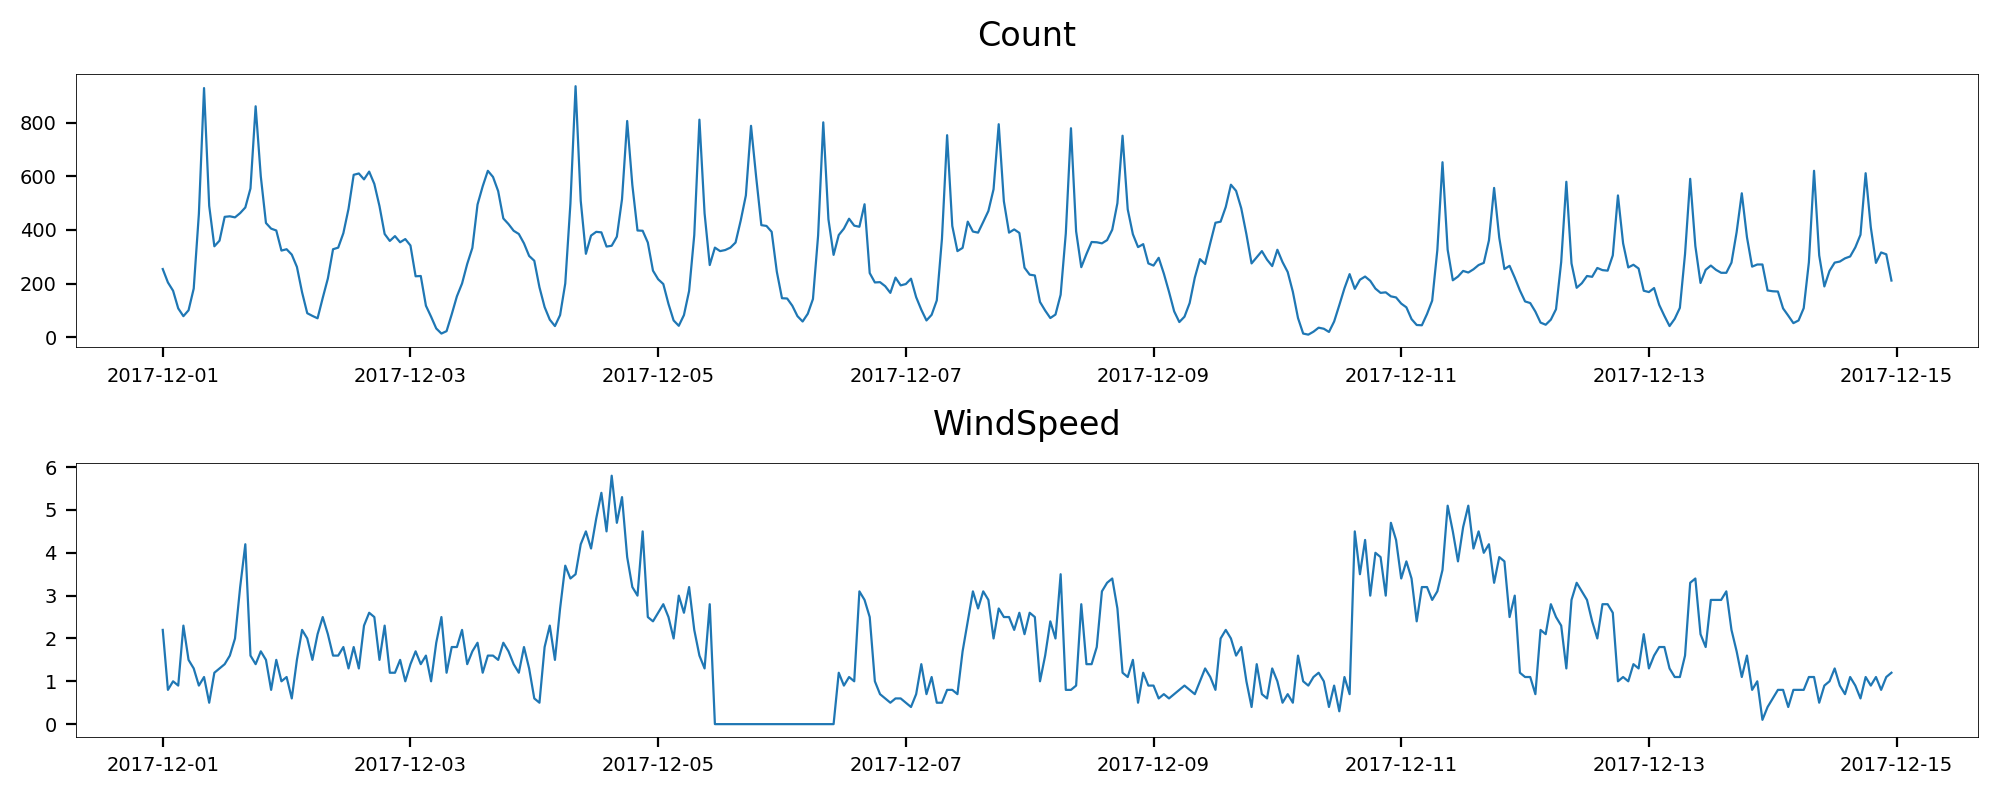

In [50]:
# 풍속 & 수요량
show_trend_count('WindSpeed', '2017-12-01 00:00:00', '2017-12-14 23:00:00')

## (2) 데이터 변화랑 시각화

- 데이터 변화량을 확인하면 데이터 변경 추이를 더욱 심도있게 확인할 수 있습니다.

0     NaN
1     2.0
2     4.0
3     7.0
4    -3.0
5    -5.0
6     1.0
7     5.0
8    -1.0
9     5.0
10   -7.0
dtype: float64


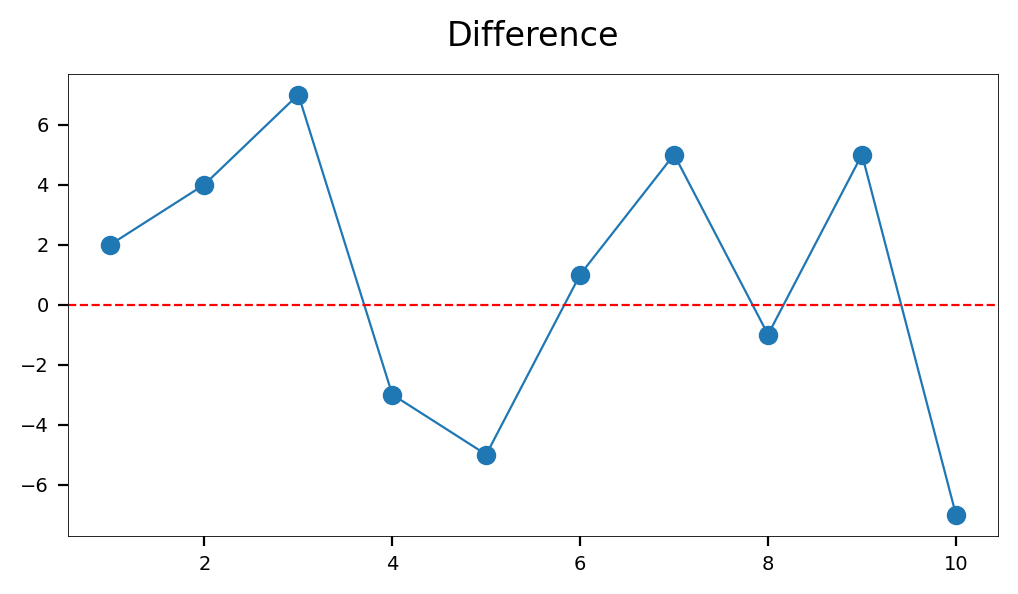

In [52]:
# 변화량
nums = [10, 12, 16, 23, 20, 15, 16, 21, 20, 25, 18]
nums_diff = pd.Series(nums).diff()
print(nums_diff)

# 시각화
plt.figure(figsize=(6, 3))
plt.plot(nums_diff, marker='o', linewidth=0.8)
plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
plt.title('Difference', size=12, pad=10)
plt.show()

**1) 수요량 변화량**

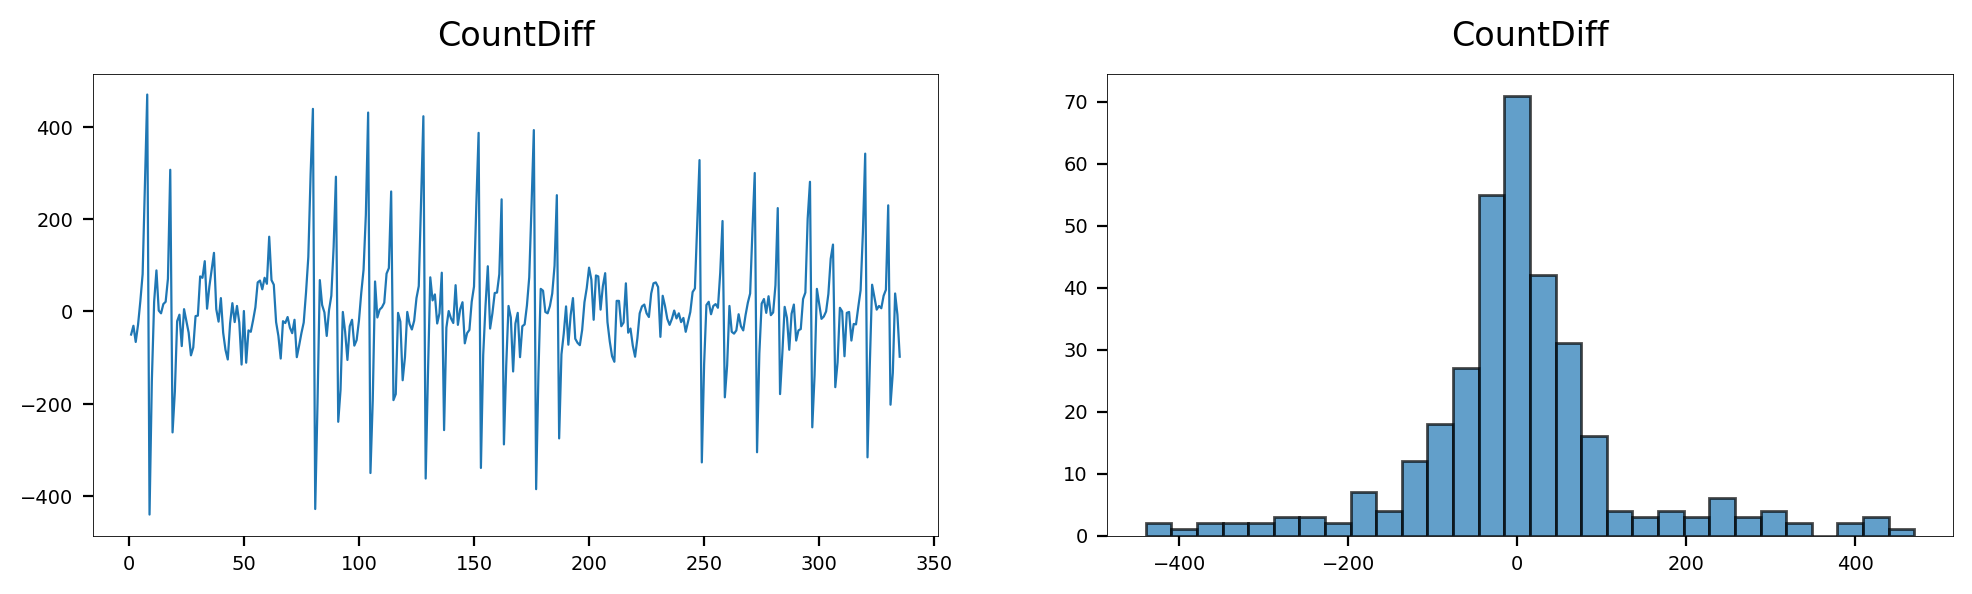

In [57]:
# 수요량 변화량(2주간)
temp = data[:24 * 14]
temp['CountDiff'] = temp['Count'].diff()

# 시각화
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(temp['CountDiff'], linewidth=0.8)
plt.title('CountDiff', size=12, pad=10)
plt.subplot(1, 2, 2)
plt.hist(temp['CountDiff'], bins=30, alpha=0.7, ec='k')
plt.title('CountDiff', size=12, pad=10)
plt.show()

**2) 요일별 변화량**

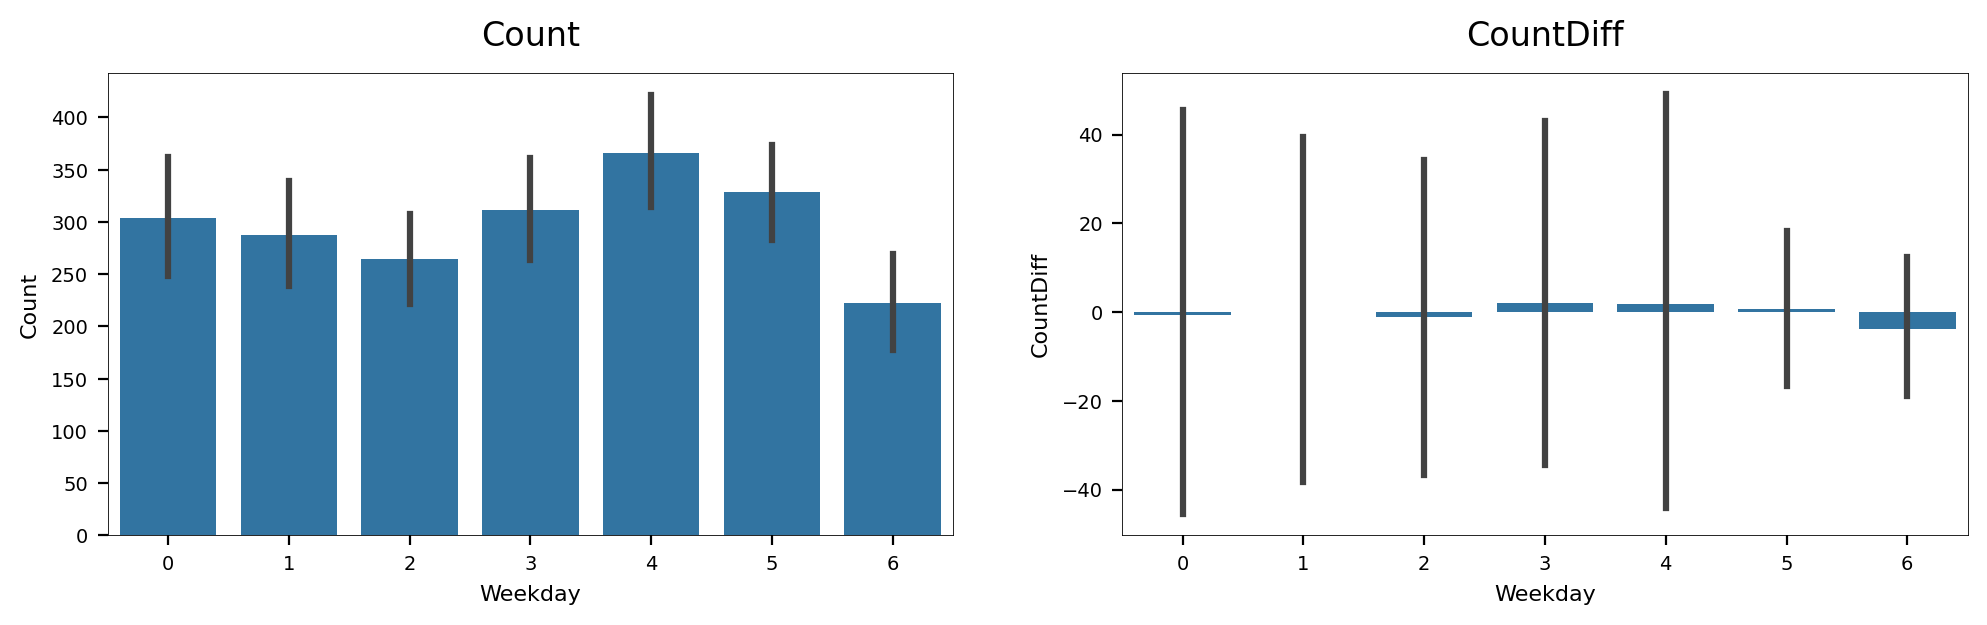

In [59]:
# 요일 추가
temp['Weekday'] = temp['DateTime'].dt.weekday

# 시각화
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.barplot(x='Weekday', y='Count', data=temp)
plt.title('Count', size=12, pad=10)
plt.subplot(1, 2, 2)
sns.barplot(x='Weekday', y='CountDiff', data=temp)
plt.title('CountDiff', size=12, pad=10)
plt.show()

**3) 시간대별 변화량**

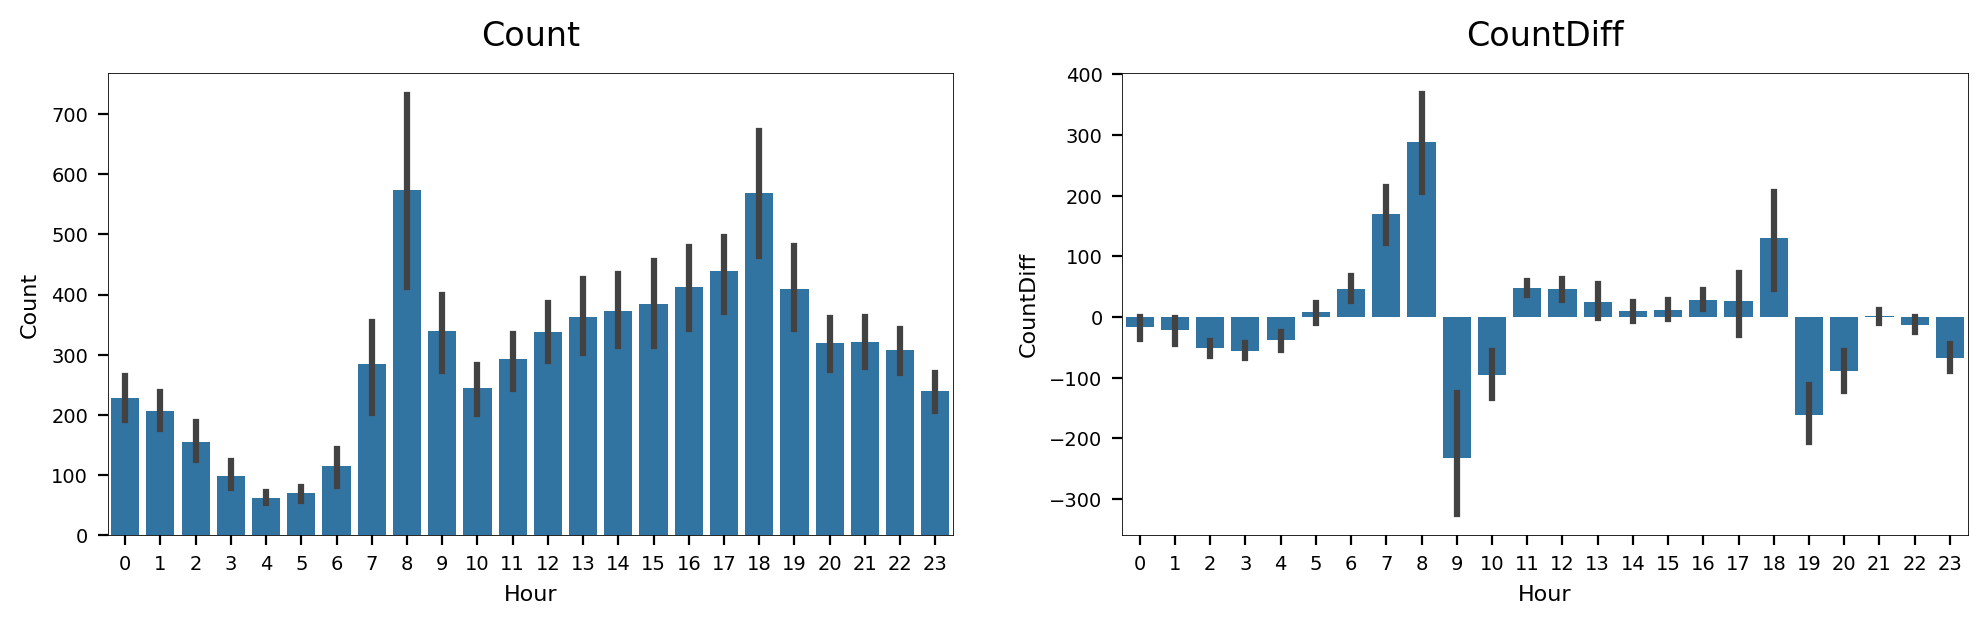

In [61]:
# 시간대 추가
temp['Hour'] = temp['DateTime'].dt.hour

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.barplot(x='Hour', y='Count', data=temp)
plt.title('Count', size=12, pad=10)
plt.subplot(1, 2, 2)
sns.barplot(x='Hour', y='CountDiff', data=temp)
plt.title('CountDiff', size=12, pad=10)
plt.show()

## (3) 자기상관 분석 (Autocorrelation Analysis)

- 자기상관 분석은 시계열 데이터 내에서 한 시점의 값이 이전 시점의 값과 어떤 관계를 가지는지를 측정하는 통계적 방법입니다.
- 자기상관이란, 시계열 데이터 내에서의 서로 다른 시점 사이의 상관관계, 즉 한 변수의 현재 값과 그 변수의 과거 또는 미래 값 사이의 상관 관계를 의미합니다.
- 이를 통해 시간의 흐름에 따라 데이터 패턴이 얼마나 유사한지를 파악할 수 있습니다.
- 시계열 데이터의 속성을 이해하고, 예측 모델링에 있어 중요한 지연 변수를 식별하는 데 유용합니다.
- 해당 데이터를 모델링하기 전에 자기상관 분석을 수행하여 데이터의 시간적 구조를 분석할 수 있습니다.

In [65]:
data[['Count']]

,Count
0,254
1,204
2,173
3,107
4,78
...,...
8035,1507
8036,1176
8037,1069
8038,1088


,Count,Count_Lag_1,Count_Lag_2,Count_Lag_3,Count_Lag_4,Count_Lag_5,Count_Lag_6,Count_Lag_7,Count_Lag_8,Count_Lag_9,...,Count_Lag_41,Count_Lag_42,Count_Lag_43,Count_Lag_44,Count_Lag_45,Count_Lag_46,Count_Lag_47,Count_Lag_48,Count_Lag_49,Count_Lag_50
Count,1.0,0.906698,0.770556,0.651137,0.539161,0.423944,0.323494,0.24441,0.194031,0.18802,...,0.165489,0.229463,0.304697,0.384728,0.461161,0.538162,0.61658,0.664531,0.615882,0.535103


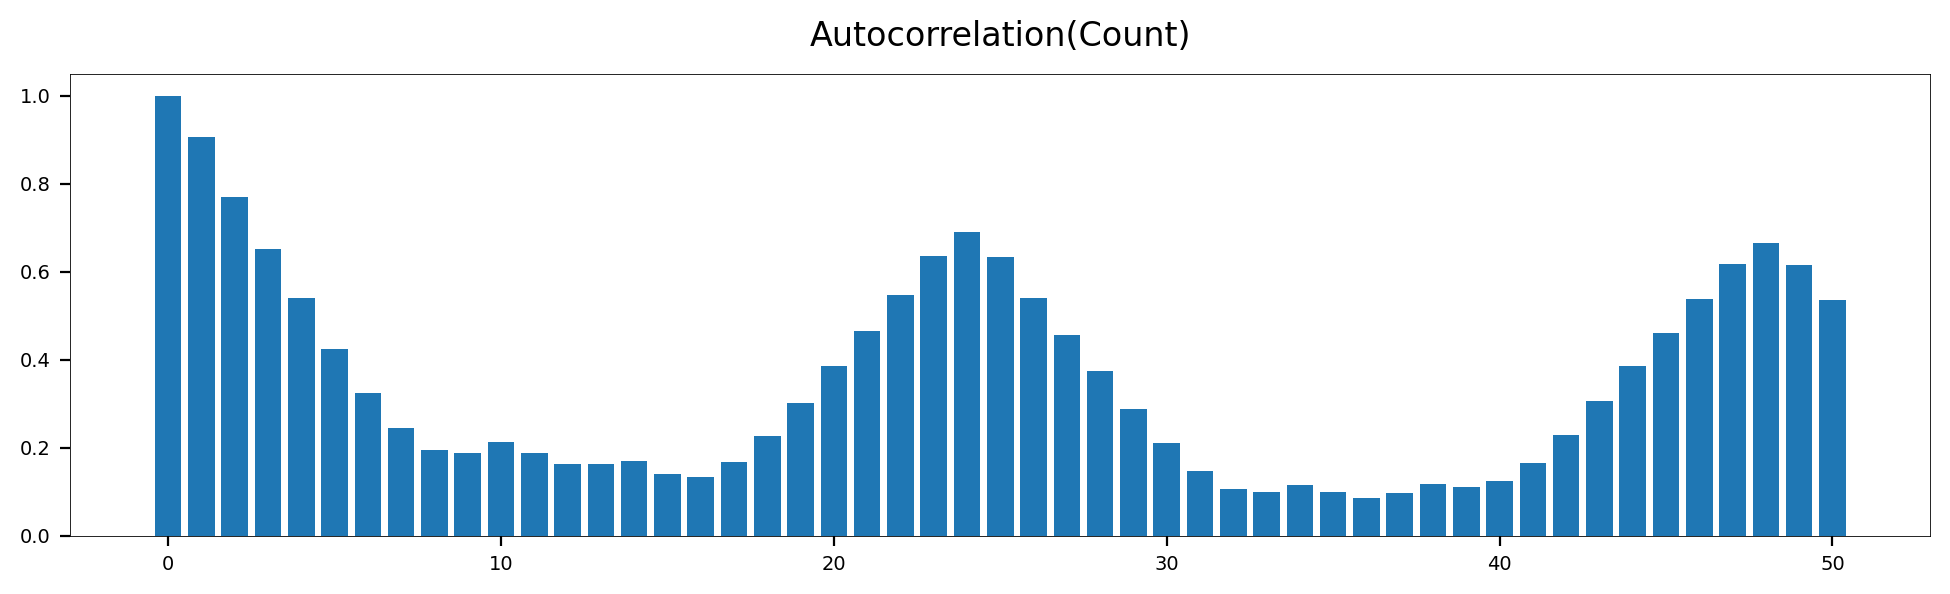

In [63]:
# 데이터프레임 만들기
temp = data[['Count']]

# 지연 속성 50개 추가
for x in range(1, 51):
    temp[f'Count_Lag_{x}'] = temp['Count'].shift(x)
temp.dropna(inplace=True)

# 상관계수
tmp = temp.corr()[['Count']][0:]
display(tmp.T)

# 시각화
plt.figure(figsize=(12, 3))
plt.bar(x=range(51), height=tmp['Count'])
plt.title('Autocorrelation(Count)', size=12, pad=10)
plt.show()

# 시계열 데이터의 자기상관관계가 높다 > 시간에 따라 예측을 할 수 있다 

In [67]:
temp

,Count,Count_Lag_1,Count_Lag_2,Count_Lag_3,Count_Lag_4,Count_Lag_5,Count_Lag_6,Count_Lag_7,Count_Lag_8,Count_Lag_9,...,Count_Lag_41,Count_Lag_42,Count_Lag_43,Count_Lag_44,Count_Lag_45,Count_Lag_46,Count_Lag_47,Count_Lag_48,Count_Lag_49,Count_Lag_50
50,228,227.0,342.0,366.0,354.0,377.0,359.0,385.0,489.0,572.0,...,490.0,930.0,460.0,181.0,100.0,78.0,107.0,173.0,204.0,254.0
51,117,228.0,227.0,342.0,366.0,354.0,377.0,359.0,385.0,489.0,...,339.0,490.0,930.0,460.0,181.0,100.0,78.0,107.0,173.0,204.0
52,76,117.0,228.0,227.0,342.0,366.0,354.0,377.0,359.0,385.0,...,360.0,339.0,490.0,930.0,460.0,181.0,100.0,78.0,107.0,173.0
53,32,76.0,117.0,228.0,227.0,342.0,366.0,354.0,377.0,359.0,...,449.0,360.0,339.0,490.0,930.0,460.0,181.0,100.0,78.0,107.0
54,13,32.0,76.0,117.0,228.0,227.0,342.0,366.0,354.0,377.0,...,451.0,449.0,360.0,339.0,490.0,930.0,460.0,181.0,100.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,1507,2094.0,1462.0,1185.0,994.0,963.0,983.0,907.0,818.0,717.0,...,283.0,440.0,488.0,658.0,906.0,979.0,1026.0,1377.0,1987.0,1274.0
8036,1176,1507.0,2094.0,1462.0,1185.0,994.0,963.0,983.0,907.0,818.0,...,182.0,283.0,440.0,488.0,658.0,906.0,979.0,1026.0,1377.0,1987.0
8037,1069,1176.0,1507.0,2094.0,1462.0,1185.0,994.0,963.0,983.0,907.0,...,150.0,182.0,283.0,440.0,488.0,658.0,906.0,979.0,1026.0,1377.0
8038,1088,1069.0,1176.0,1507.0,2094.0,1462.0,1185.0,994.0,963.0,983.0,...,162.0,150.0,182.0,283.0,440.0,488.0,658.0,906.0,979.0,1026.0


- 자기상관 분석을 통해 자전거 수요량(Count)에 대한 자기상관도를 시각화한 결과입니다.
- 이 그래프는 최대 50시간의 지연(lag)까지의 자기상관도를 보여줍니다.
- 자기상관도가 높은 지연 값은 해당 시간 간격만큼 이전의 자전거 수요량이 현재 수요량과 상당한 상관 관계를 가지고 있음을 의미합니다.
- 그래프에서 볼 수 있듯이, 초기 몇 시간의 지연에서 상대적으로 높은 자기상관도를 관찰할 수 있습니다.
- 이는 과거의 자전거 수요량이 단기간 내에서 현재 수요량을 예측하는 데 중요한 정보를 제공할 수 있음을 알려줍니다.
-  참고로, 다음과 같이 자기상관함수(ACF)를 사용해 시각화할 수도 있습니다.

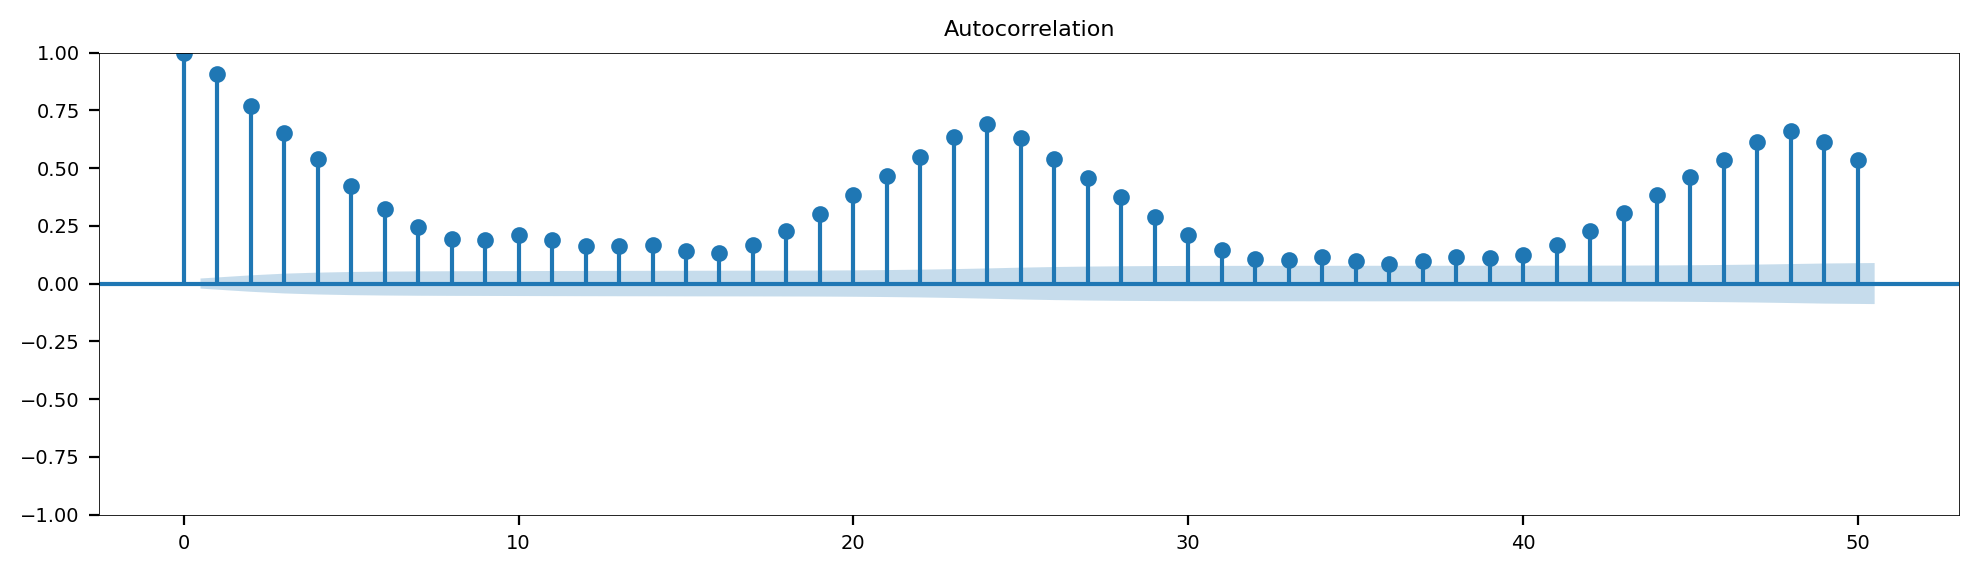

In [69]:
# 모듈 불러오기
from statsmodels.graphics.tsaplots import plot_acf

# 자기상관 분석 시각화
fig, ax = plt.subplots(figsize=(12, 3))
plot_acf(data['Count'], lags=50, alpha=0.05, ax=ax)
plt.show()

## (4) 교차 상관 분석 (Cross-Correlation Analysis)

- 교차 상관 분석은 두 시계열 데이터 집합 사이의 상관 관계를 시간의 변화에 따라 분석하는 통계적 방법입니다.
- 이 방법은 한 시계열의 현재 값이 다른 시계열의 과거 또는 미래 값과 어떤 관계를 가지는지를 측정하여, 두 시계열 사이의 상호 연관성을 파악할 수 있게 해줍니다.
- 교차 상관 분석은 다양한 분야에서 응용될 수 있습니다.
- 예를 들어, 경제학에서는 특정 경제 지표가 다른 지표에 미치는 영향을 시간적으로 분석하기 위해 사용됩니다.
- 환경 과학에서는 기온 변화가 특정 생태계에 미치는 영향을 분석하는 데 사용되기도 합니다.
- 또한, 신호 처리에서는 두 신호 간의 상호 연관성을 분석하여 동기화되거나 연관된 부분을 찾아내는 데 활용됩니다.
- 교차 상관 분석을 통해, 두 시계열 데이터 사이의 동적인 관계를 이해하고, 이를 바탕으로 예측 모델을 개선하거나 시스템의 동작 원리를 해석하는 등의 인사이트를 얻을 수 있습니다.

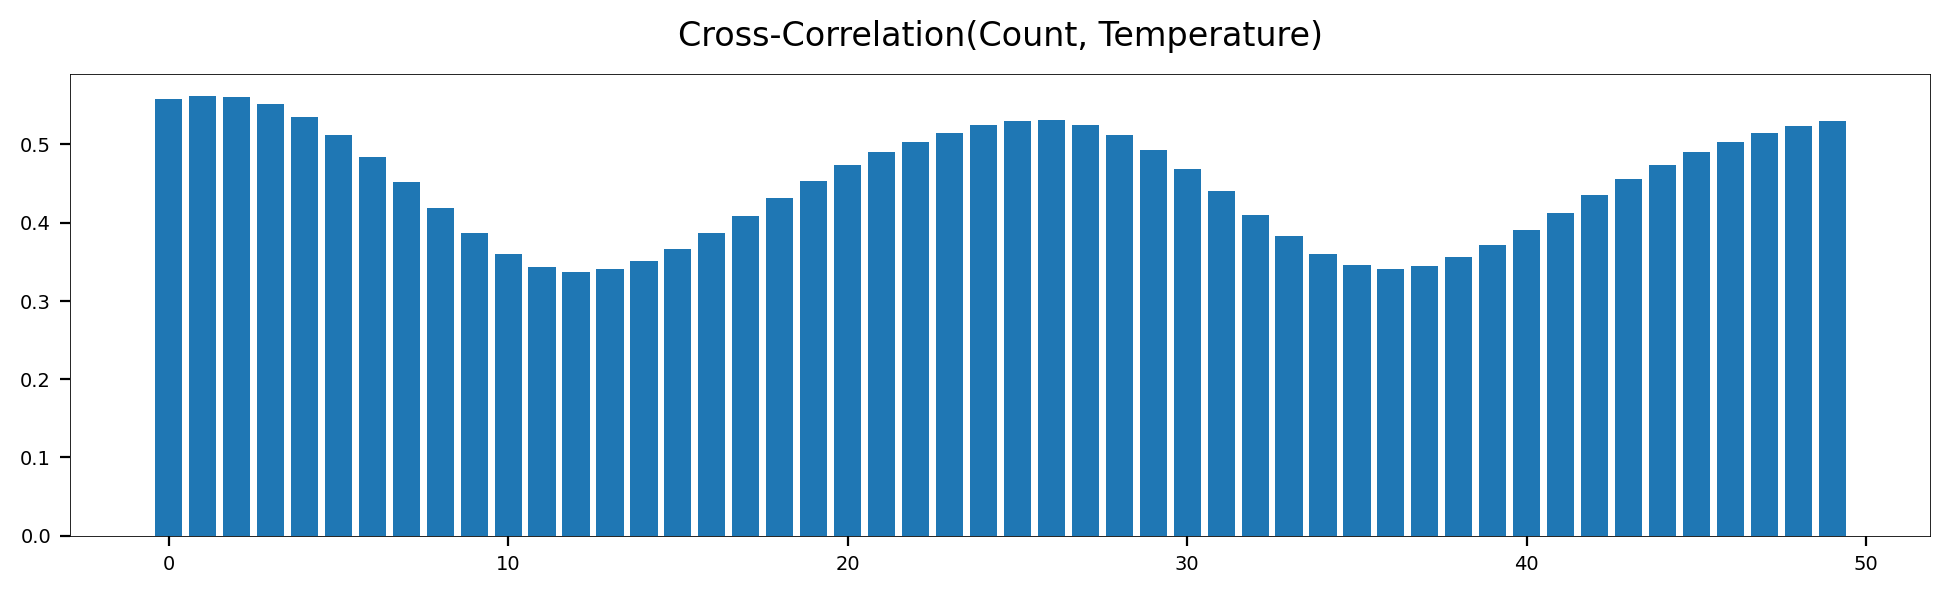

In [71]:
# 데이터프레임 만들기
temp = data[['Count']]

# 지연 속성 추가
for x in range(1, 51):
    temp[f'Temp_Lag_{x}'] = data['Temperature'].shift(x) # 교차 상관계수 
temp.dropna(inplace=True)

# 상관계수
tmp = temp.corr()['Count'][1:]

# 시각화
plt.figure(figsize=(12, 3))
plt.bar(x=range(50), height=tmp)
plt.title('Cross-Correlation(Count, Temperature)', size=12, pad=10)
plt.show()

- 교차 상관 분석을 통해 자전거 수요량(Count)과 온도(Temperature) 사이의 교차 상관도를 시각화한 결과입니다.
- 이 그래프는 최대 50시간 지연까지의 교차 상관 계수를 보여주며, 각 지연 시간에서의 온도와 자전거 수요량 간의 상관 관계를 나타냅니다.
- 그래프에서 볼 수 있듯이, 초기 몇 시간의 지연에서 상관 관계가 나타날 수 있으며, 이는 온도 변화가 자전거 수요에 단기간 내에 영향을 줄 수 있음을 시사합니다.
- 특히 단기간 내의 지연 특성이 유용할 가능성이 있음을 보여줍니다.
- 참고로 다음과 같이 교차상관함수(CCF)를 사용해 분석할 수도 있습니다.

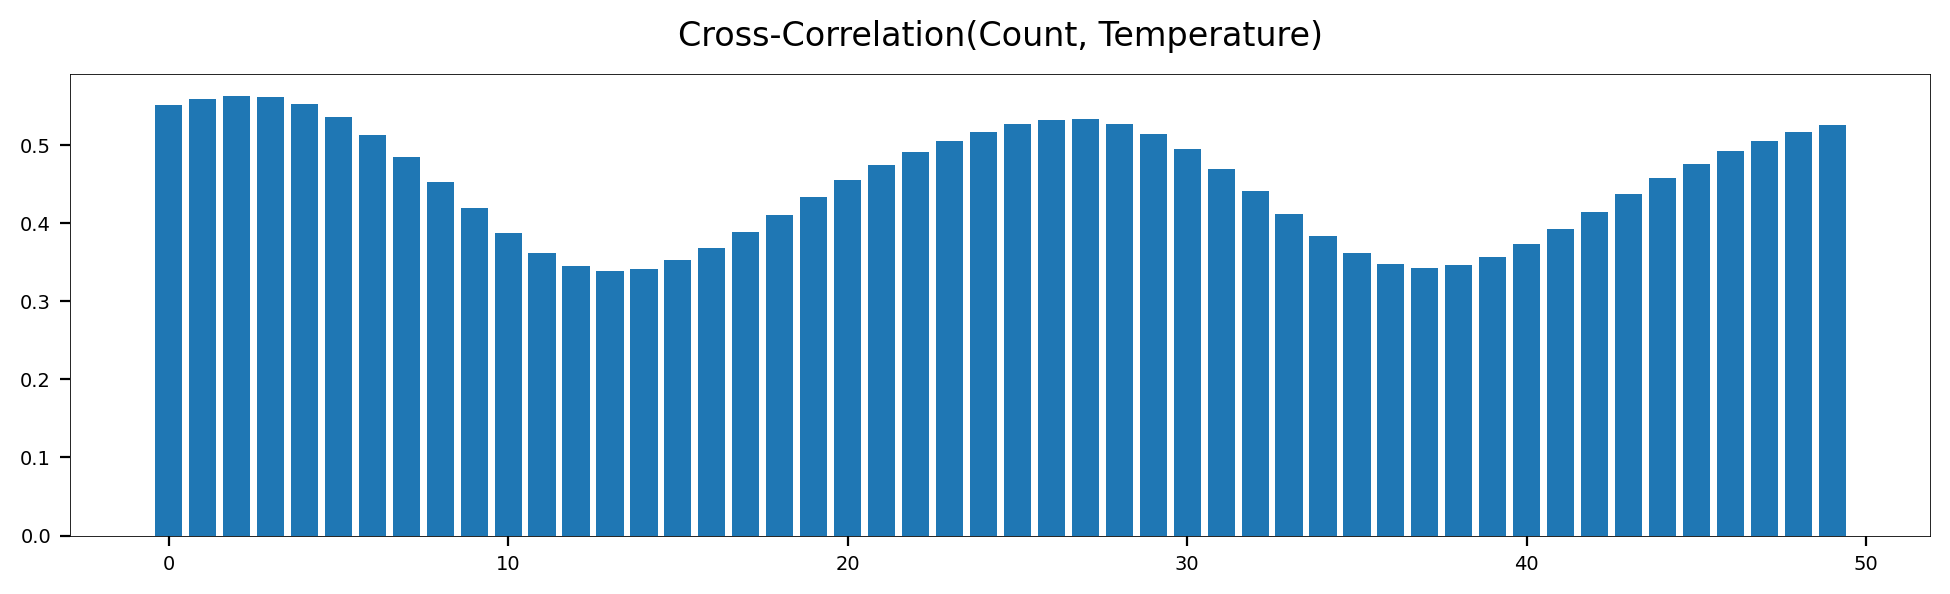

In [73]:
# 모듈 불러오기
from statsmodels.tsa.stattools import ccf

# 교차 상관 계수 계산
ccf_values = ccf(data['Count'], data['Temperature'])[:50]

# 시각화
plt.figure(figsize=(12, 3))
plt.bar(range(50), ccf_values)
plt.title('Cross-Correlation(Count, Temperature)', size=12, pad=10)
plt.show()

## (5) 주요 변수의 변화 시각화

- 주요 변수의 변화 분석은 데이터 내에서 특정 변수들이 어떻게 변화하며, 이러한 변화가 전체 데이터 셋이나 다른 변수들과 어떤 관계를 가지는지를 파악하는 과정입니다.
- 이 분석을 통해 변수 간의 관계, 패턴, 추세, 그리고 예외 사항들을 식별할 수 있습니다.
- 특히, 시계열 데이터나 복잡한 데이터 세트를 다룰 때, 주요 변수들의 동적인 변화를 이해하는 것은 중요한 인사이트를 제공하고, 예측 모델의 정확도를 향상시키는 데 기여할 수 있습니다.
- 주요 변수의 변화를 분석하기 위해, 우리는 자전거 수요에 영향을 미칠 수 있는 몇 가지 변수들에 대해 분석을 진행할 것입니다.
- 여기에는 온도(Temperature), 습도(Humidity), 풍속(WindSpeed) 등의 환경 변수와 계절(Seasons), 공휴일(Holiday) 등의 시간적 변수가 포함됩니다.
- 이러한 분석을 통해 각 변수가 자전거 수요량에 어떤 영향을 미치는지 파악할 수 있으며, 이를 통해 특정 상황에서의 수요 패턴을 이해할 수 있습니다.

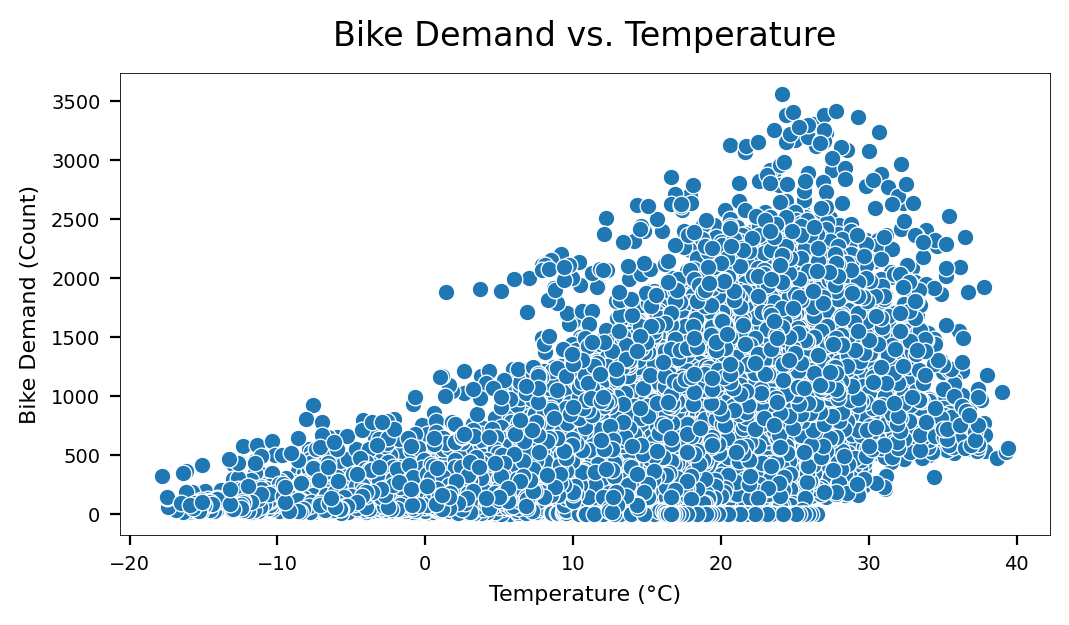

In [77]:
# 온도 & 수요량
plt.figure(figsize=(6, 3))
sns.scatterplot(x='Temperature', y='Count', data=data)
plt.title('Bike Demand vs. Temperature', size=12, pad=10)
plt.xlabel('Temperature (°C)')
plt.ylabel('Bike Demand (Count)')
plt.show()

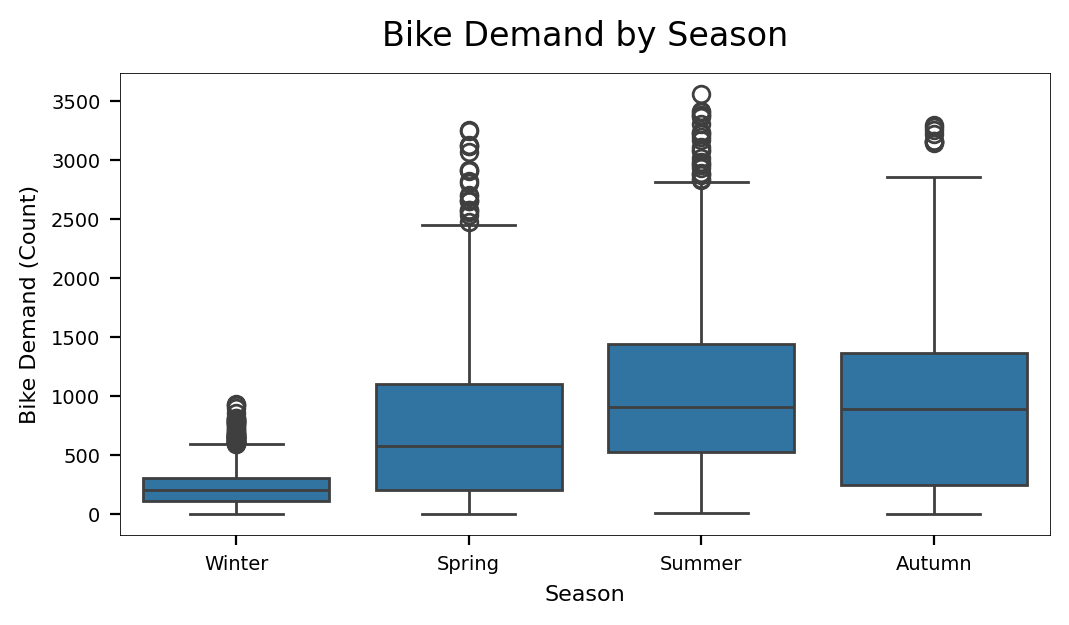

In [79]:
# 계절 & 수요량
plt.figure(figsize=(6, 3))
sns.boxplot(x='Seasons', y='Count', data=data)
plt.title('Bike Demand by Season', size=12, pad=10)
plt.xlabel('Season')
plt.ylabel('Bike Demand (Count)')
plt.show()

## (6) 시계열 데이터 분해

- 시계열 데이터 분해는 시계열 데이터를 여러 구성 요소로 분리하는 분석 기법입니다.
- 이를 통해 데이터 내의 패턴을 명확히 파악하고, 더 정교한 예측과 분석을 가능하게 합니다.
- 시계열 데이터 분해의 주요 목적은 데이터의 추세, 계절성, 그리고 잔차(또는 불 요소를 식별하는 것입니다.

In [81]:
# 모듈 불러오기
import statsmodels.api as sm

# 시계열 데이터 분해
temp = data.loc[data['DateTime'].between('2017-12-01 00:00:00', '2017-12-31 23:00:00')]
decomp = sm.tsa.seasonal_decompose(temp['Count'], model='additive', period=24)

# 시계열 분해 결과를 받아서 데이터프레임으로 저장
result = pd.DataFrame({'observed':decomp.observed,
                       'trend':decomp.trend,
                       'seasonal':decomp.seasonal,
                       'residual':decomp.resid})

### 1) 원본 데이터 (Observed)

- 원본 Count 데이터는 일별 자전거 수요량을 시간별로 보여줍니다.

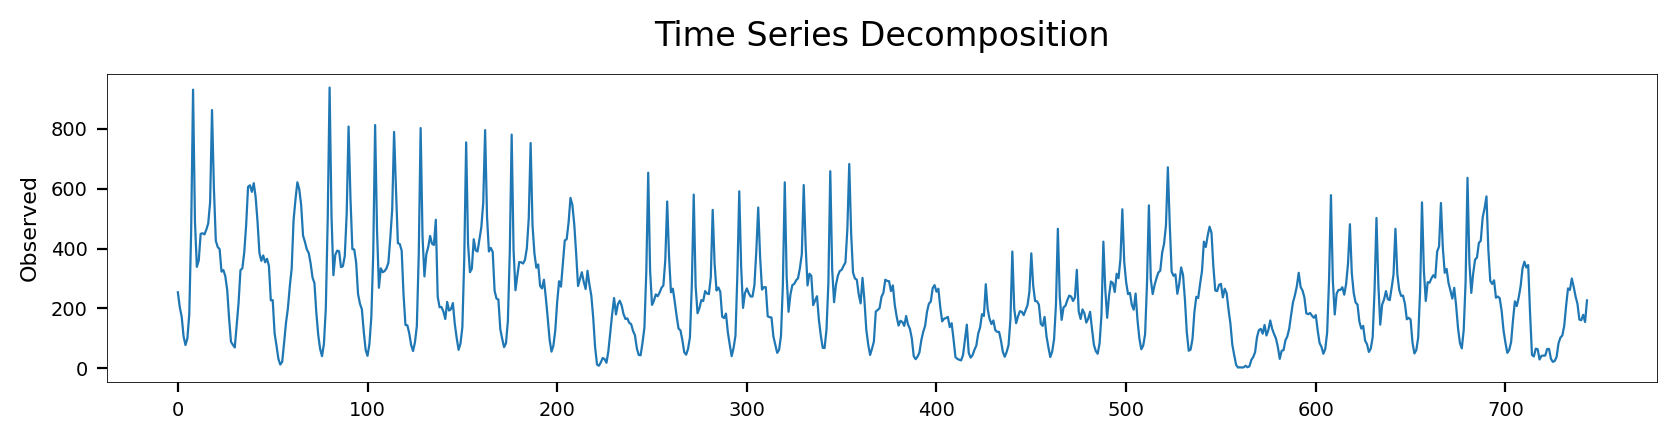

In [83]:
# Observed
plt.figure(figsize=(10, 2))
plt.plot(result['observed'], linewidth=0.8)
plt.title('Time Series Decomposition', size=12, pad=10)
plt.ylabel('Observed')
plt.show()

### 2) 추세(Trend)
- 의미: 시계열 데이터의 장기적인 이동 평균을 나타냅니다. 추세는 데이터의 증가 또는 감소하는 방향성을 보여줍니다.
- 예시: 주식 시장의 장기적 상승 추세 또는 기후 변화에 따른 온도 상승 추세 등

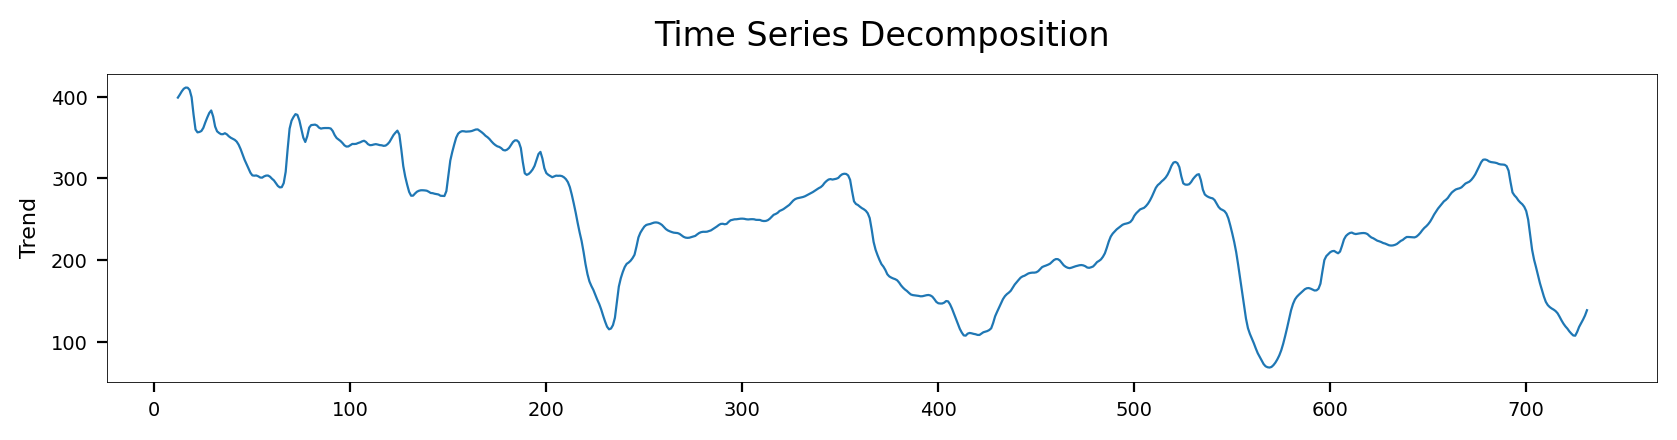

In [85]:
# Trend
plt.figure(figsize=(10, 2))
plt.plot(result['trend'], linewidth=0.8)
plt.title('Time Series Decomposition', size=12, pad=10)
plt.ylabel('Trend')
plt.show()

- 추세는 시간이 지남에 따라 자전거 수요량의 변화를 보여주는 부드러운 곡선을 표시합니다.
- 이는 장기적인 변동성을 나타내며, 일반적으로 시간에 따라 증가하거나 감소하는 경향을 보여줍니다.
- 12월의 경우, 대체로 자전거 수요량이 점차 감소하는 추세를 보여주는 것으로 나타납니다.

### 3) 계절성(Seasonality)
- 의미: 시계열 데이터의 주기적 변동을 나타내며, 일정 기간을 주기로 반복됩니다. 이는 일, 주, 월, 분기 등의 주기적 패턴에서 나타나는 변동입니다.
- 예시: 소매업에서 크리스마스 전 증가하는 판매량, 주말마다 늘어나는 레스토랑의 고객 수 등

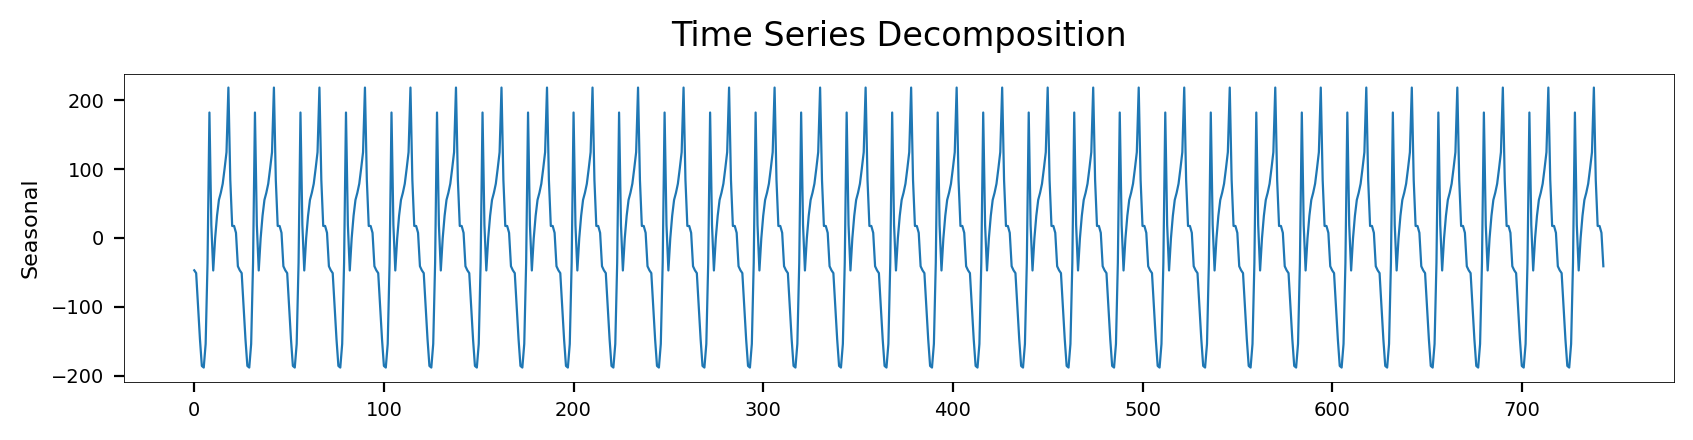

In [88]:
# Seasonality
plt.figure(figsize=(10, 2))
plt.plot(result['seasonal'], linewidth=0.8)
plt.title('Time Series Decomposition', size=12, pad=10)
plt.ylabel('Seasonal')
plt.show()

- 계절성은 하루 동안의 변동 패턴을 보여줍니다.
- 특히, 낮 시간에 자전거 수요량이 증가하고 밤 시간에 감소하는 일반적인 패턴을 보여줍니다.
- 이는 사람들의 일상 생활 패턴(출퇴근 시간의 수요량 증가 등)을 반영합니다.

### 4) 잔차(Residual)
- 의미: 추세와 계절성을 데이터에서 제거한 후 남는 잔여 변동성을 말합니다. 이는 데이터의 불규칙한 변동을 포함하며, 예측이 어려운 부분입니다.
- 예시: 예상치 못한 이벤트, 데이터의 측정 오류, 기타 외부 영향 등에 의해 발생합니다.

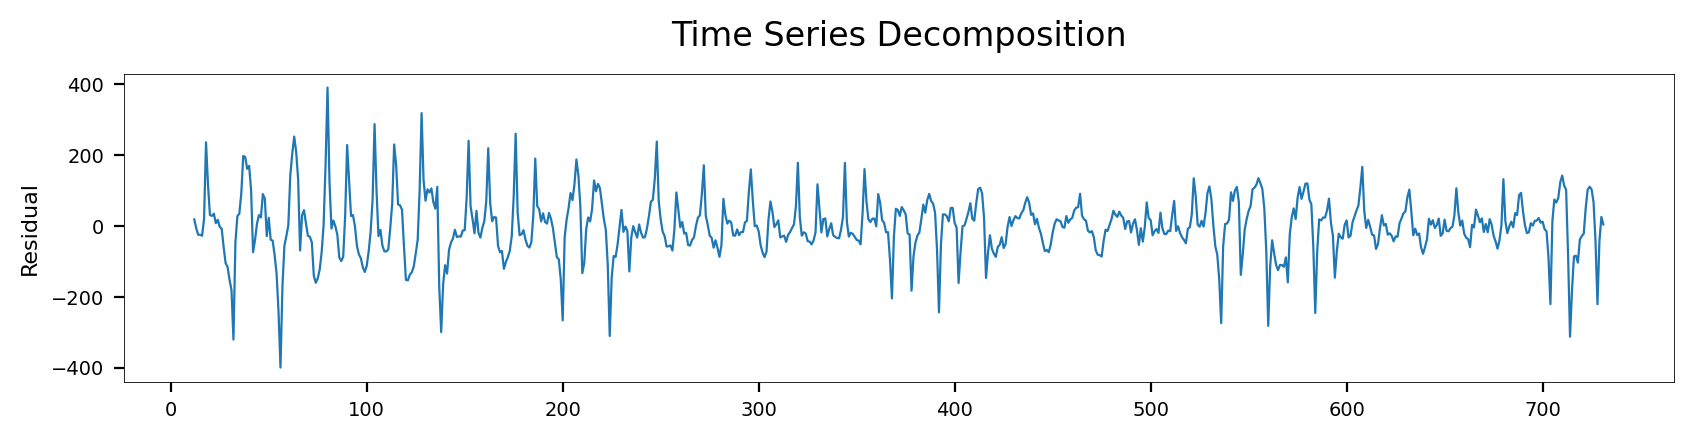

In [92]:
# Residual
plt.figure(figsize=(10, 2))
plt.plot(result['residual'], linewidth=0.8)
plt.title('Time Series Decomposition', size=12, pad=10)
plt.ylabel('Residual')
plt.show()

- 잔차는 모델이 추세와 계절성을 제거한 후 남은 변동성을 보여줍니다.
- 이는 데이터의 불규칙한 변동을 나타내며, 시간에 따라 크게 변할 수 있습니다.
- 잔차가 낮으면 모델이 데이터의 패턴을 잘 설명하고 있다는 의미이며, 큰 잔차는 예외적인 사건이나 누락된 패턴을 나타낼 수 있습니다.

# 4. 데이터 셋 구성

- 위에서 진행한 탐색 과정을 바탕으로, 자전거 수요 예측 모델에 적절한 지연 속성을 추가하는 것이 유용할 것입니다.
- 자기상관 분석과 교차 상관 분석 결과를 통해, 단기 지연(lags)이 중요한 역할을 할 수 있음을 확인했습니다.
- 또한, 온도와 계절성이 자전거 수요량에 중요한 영향을 미침을 확인했으므로, 이러한 변수들의 지연 속성을 추가합니다.
- 모델링에 포함할 지연 속성은 다음과 같습니다.
    - 자전거 수요량(Count)의 1시간, 2시간, 3시간 전 지연
    - 온도(Temperature)의 1시간, 2시간 전 지연
    - 풍속(WindSpeed)의 1시간 전 지연 등

In [96]:
# Target 추가
data['Target'] = data['Count'].shift(-2) # 중요 미래 2일의 데이터를 예측할 것이기에 shift(-2) 를 타겟으로

# Hour, Weekday 추가
data['Hour'] = data['DateTime'].dt.hour
data['Weekday'] = data['DateTime'].dt.day_name()

# Count 지연 속성 추가
data['Count_Lag_1'] = data['Count'].shift(1)
data['Count_Lag_2'] = data['Count'].shift(2)
data['Count_Lag_3'] = data['Count'].shift(3)

# Temperature 지연 속성 추가
data['Temperature_Lag_1'] = data['Temperature'].shift(1)
data['Temperature_Lag_2'] = data['Temperature'].shift(2)

# WindSpeed 지연 속성 추가
data['WindSpeed_Lag_1'] = data['WindSpeed'].shift(1)

# 최근 2일간 수요량 평균
data['Count_Mean_2'] = data['Count'].rolling(2, min_periods=1).mean()

# 최근 3일간 수요량 평균
data['Count_Mean_3'] = data['Count'].rolling(3, min_periods=1).mean()

# 최근 7일간 수요량 평균
data['Count_Mean_7'] = data['Count'].rolling(7, min_periods=1).mean()

# NaN 값이 생성된 행 제거
data.dropna(inplace=True)

# 확인
data.head(10)

,DateTime,Temperature,Humidity,WindSpeed,Seasons,Holiday,Count,Target,Hour,Weekday,Count_Lag_1,Count_Lag_2,Count_Lag_3,Temperature_Lag_1,Temperature_Lag_2,WindSpeed_Lag_1,Count_Mean_2,Count_Mean_3,Count_Mean_7
3,2017-12-01 03:00:00,-6.2,40,0.9,Winter,No Holiday,107,100.0,3,Friday,173.0,204.0,254.0,-6.0,-5.5,1.0,140.0,161.333333,184.500000
4,2017-12-01 04:00:00,-6.0,36,2.3,Winter,No Holiday,78,181.0,4,Friday,107.0,173.0,204.0,-6.2,-6.0,0.9,92.5,119.333333,163.200000
5,2017-12-01 05:00:00,-6.4,37,1.5,Winter,No Holiday,100,460.0,5,Friday,78.0,107.0,173.0,-6.0,-6.2,2.3,89.0,95.000000,152.666667
6,2017-12-01 06:00:00,-6.6,35,1.3,Winter,No Holiday,181,930.0,6,Friday,100.0,78.0,107.0,-6.4,-6.0,1.5,140.5,119.666667,156.714286
7,2017-12-01 07:00:00,-7.4,38,0.9,Winter,No Holiday,460,490.0,7,Friday,181.0,100.0,78.0,-6.6,-6.4,1.3,320.5,247.000000,186.142857
8,2017-12-01 08:00:00,-7.6,37,1.1,Winter,No Holiday,930,339.0,8,Friday,460.0,181.0,100.0,-7.4,-6.6,0.9,695.0,523.666667,289.857143
9,2017-12-01 09:00:00,-6.5,27,0.5,Winter,No Holiday,490,360.0,9,Friday,930.0,460.0,181.0,-7.6,-7.4,1.1,710.0,626.666667,335.142857
10,2017-12-01 10:00:00,-3.5,24,1.2,Winter,No Holiday,339,449.0,10,Friday,490.0,930.0,460.0,-6.5,-7.6,0.5,414.5,586.333333,368.285714
11,2017-12-01 11:00:00,-0.5,21,1.3,Winter,No Holiday,360,451.0,11,Friday,339.0,490.0,930.0,-3.5,-6.5,1.2,349.5,396.333333,408.571429
12,2017-12-01 12:00:00,1.7,23,1.4,Winter,No Holiday,449,447.0,12,Friday,360.0,339.0,490.0,-0.5,-3.5,1.3,404.5,382.666667,458.428571


- 구성된 데이터 셋에 대한 전처리를 수행합니다.
- 다음과 같은 과정이 포함되어야 합니다.
    - x, y 분리
    - 가변수화 등
- 학습용, 검증용, 평가용 데이터의 가변수화 결과가 일치하도록 대상 변수는 카테고리 형으로 변환합니다.

In [99]:
# x, y 분리
x = data.drop(['DateTime', 'Target'], axis=1)
y = data.loc[:, 'Target']

# 가변수화  (주의) 계절별로 학습을 할때  학습용 검증용으로 분할하게 되면 봄여름가을 데이터를 학습용으로 , 겨울 데이터를 검증용으로 사용할 것임 

# 해결방법 : pd.Categorical(x['Seasons'], categories=seasons)  <  가변수화 할때 4개의 계절이 보존된다
seasons = ['Spring', 'Summer', 'Autumn','Winter']
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holiday = ['No Holiday', 'Holiday']
x['Seasons'] = pd.Categorical(x['Seasons'], categories=seasons)
x['Weekday'] = pd.Categorical(x['Weekday'], categories=weekday)
x['Holiday'] = pd.Categorical(x['Holiday'], categories=holiday)
x = pd.get_dummies(x, drop_first=True, dtype=int)

# 확인
x.head()

,Temperature,Humidity,WindSpeed,Count,Hour,Count_Lag_1,Count_Lag_2,Count_Lag_3,Temperature_Lag_1,Temperature_Lag_2,...,Seasons_Summer,Seasons_Autumn,Seasons_Winter,Holiday_Holiday,Weekday_Tuesday,Weekday_Wednesday,Weekday_Thursday,Weekday_Friday,Weekday_Saturday,Weekday_Sunday
3,-6.2,40,0.9,107,3,173.0,204.0,254.0,-6.0,-5.5,...,0,0,1,0,0,0,0,1,0,0
4,-6.0,36,2.3,78,4,107.0,173.0,204.0,-6.2,-6.0,...,0,0,1,0,0,0,0,1,0,0
5,-6.4,37,1.5,100,5,78.0,107.0,173.0,-6.0,-6.2,...,0,0,1,0,0,0,0,1,0,0
6,-6.6,35,1.3,181,6,100.0,78.0,107.0,-6.4,-6.0,...,0,0,1,0,0,0,0,1,0,0
7,-7.4,38,0.9,460,7,181.0,100.0,78.0,-6.6,-6.4,...,0,0,1,0,0,0,0,1,0,0


# 5. 모델링

- Random Forest 모델을 만들어 성능을 검증합니다.
- 성능 향상을 위해 변수 추가, 하이퍼파라미터 튜닝을 진행할 수 있습니다.

In [106]:
# 불러오기
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# 학습용, 검증용 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=24*30, shuffle=False, random_state=1)
# 중요! 시계열 데이터는 학습할때 shuffle=False 섞으면 안됌
# test_size=24*30 ?  24시간 x 30  >> 즉 1달치 데이터를 검증용으로 사용할 것이다 
# 선언하기
model = RandomForestRegressor(random_state=1)

# 학습하기
model.fit(x_train, y_train)

# 예측하기
y_val_pred = model.predict(x_val)

# 평가하기
print('RMSE:',  root_mean_squared_error(y_val, y_val_pred))
print('R2:',  r2_score(y_val, y_val_pred))

RMSE: 234.04394417234982
R2: 0.873424500530926


- 예측 결과를 시각화해 봅니다.
- 다음과 같은 함수를 만들어 활용하면 좋습니다.

In [108]:
# 함수 만들기
def plot_model_result(y_train, y_val, y_pred):
    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))
    y_pred = pd.Series(y_pred.reshape(-1,), index=y_val.index)

    # 전체 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(2,1,1)
    plt.plot(y_train, label='Train', color='tab:blue', linewidth=0.8)
    plt.plot(y_val, label='Test', color='tab:green', linewidth=0.8)
    plt.plot(y_pred, label='Pred', color='tab:orange', linewidth=0.8)
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'Test', color='tab:green', linewidth=0.8)
    plt.plot(y_pred, label = 'Pred', color='tab:orange', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

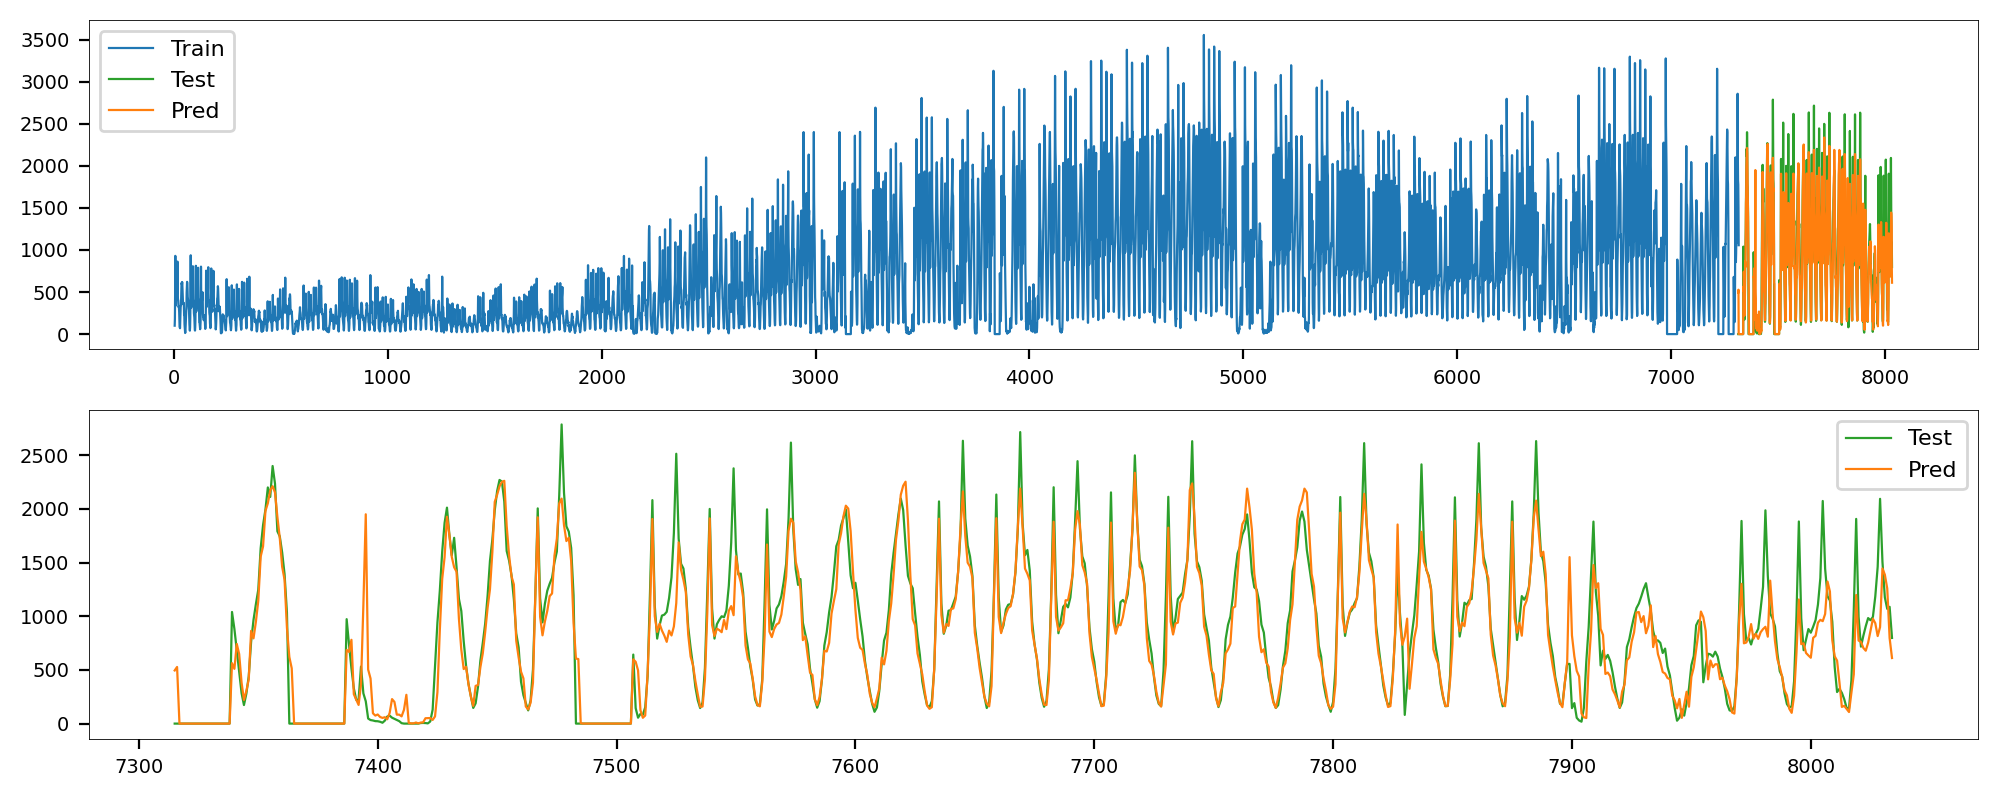

In [110]:
# 예측 결과 시각화
plot_model_result(y_train, y_val, y_val_pred)

# 6. 최종 예측과 평가

- 새로운 데이터, 즉 평가 데이터에 대한 예측을 수행하고 성능을 확인합니다.
- 모델링 과정에서 수행한 데이터 셋 구성과 전처리 과정이 새로운 데이터에 대해서도 동일하게 수행되어야 합니다.

In [112]:
# Target 추가 > 평가용 데이터 역시 시계열로 변환해주는데 이를 만드는 함수를 만들면 평가도 편해짐 
data_test['Target'] = data_test['Count'].shift(-2)
data_test.dropna(inplace=True)

# Hour, Weekday 추가
data_test['Hour'] = data_test['DateTime'].dt.hour
data_test['Weekday'] = data_test['DateTime'].dt.day_name()

# Count 지연 속성 추가
data_test['Count_Lag_1'] = data_test['Count'].shift(1)
data_test['Count_Lag_2'] = data_test['Count'].shift(2)
data_test['Count_Lag_3'] = data_test['Count'].shift(3)

# Temperature 지연 속성 추가
data_test['Temperature_Lag_1'] = data_test['Temperature'].shift(1)
data_test['Temperature_Lag_2'] = data_test['Temperature'].shift(2)

# WindSpeed 지연 속성 추가
data_test['WindSpeed_Lag_1'] = data_test['WindSpeed'].shift(1)

# 최근 2일간 수요량 평균
data_test['Count_Mean_2'] = data_test['Count'].rolling(2, min_periods=1).mean()

# 최근 3일간 수요량 평균
data_test['Count_Mean_3'] = data_test['Count'].rolling(3, min_periods=1).mean()

# 최근 7일간 수요량 평균
data_test['Count_Mean_7'] = data_test['Count'].rolling(7, min_periods=1).mean()

# NaN 값이 생성된 행 제거
data_test.dropna(inplace=True)

In [114]:
# x, y 분리
x_test = data_test.drop(['DateTime', 'Target'], axis=1)
y_test = data_test.loc[:, 'Target']

# 가변수화
seasons = ['Spring', 'Summer', 'Autumn','Winter']
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holiday = ['No Holiday', 'Holiday']
x_test['Seasons'] = pd.Categorical(x_test['Seasons'], categories=seasons)
x_test['Weekday'] = pd.Categorical(x_test['Weekday'], categories=weekday)
x_test['Holiday'] = pd.Categorical(x_test['Holiday'], categories=holiday)
x_test= pd.get_dummies(x_test, drop_first=True, dtype=int)

- 이제 모델로 예측하고 성능을 확인합니다.

In [117]:
# 예측하기
y_test_pred = model.predict(x_test)

# 평가하기
print('RMSE:', root_mean_squared_error(y_test, y_test_pred))
print('R2:',  r2_score(y_test, y_test_pred))

RMSE: 203.59067381953847
R2: 0.8229466922653562


- 예측 결과를 시각화해 확인합니다.

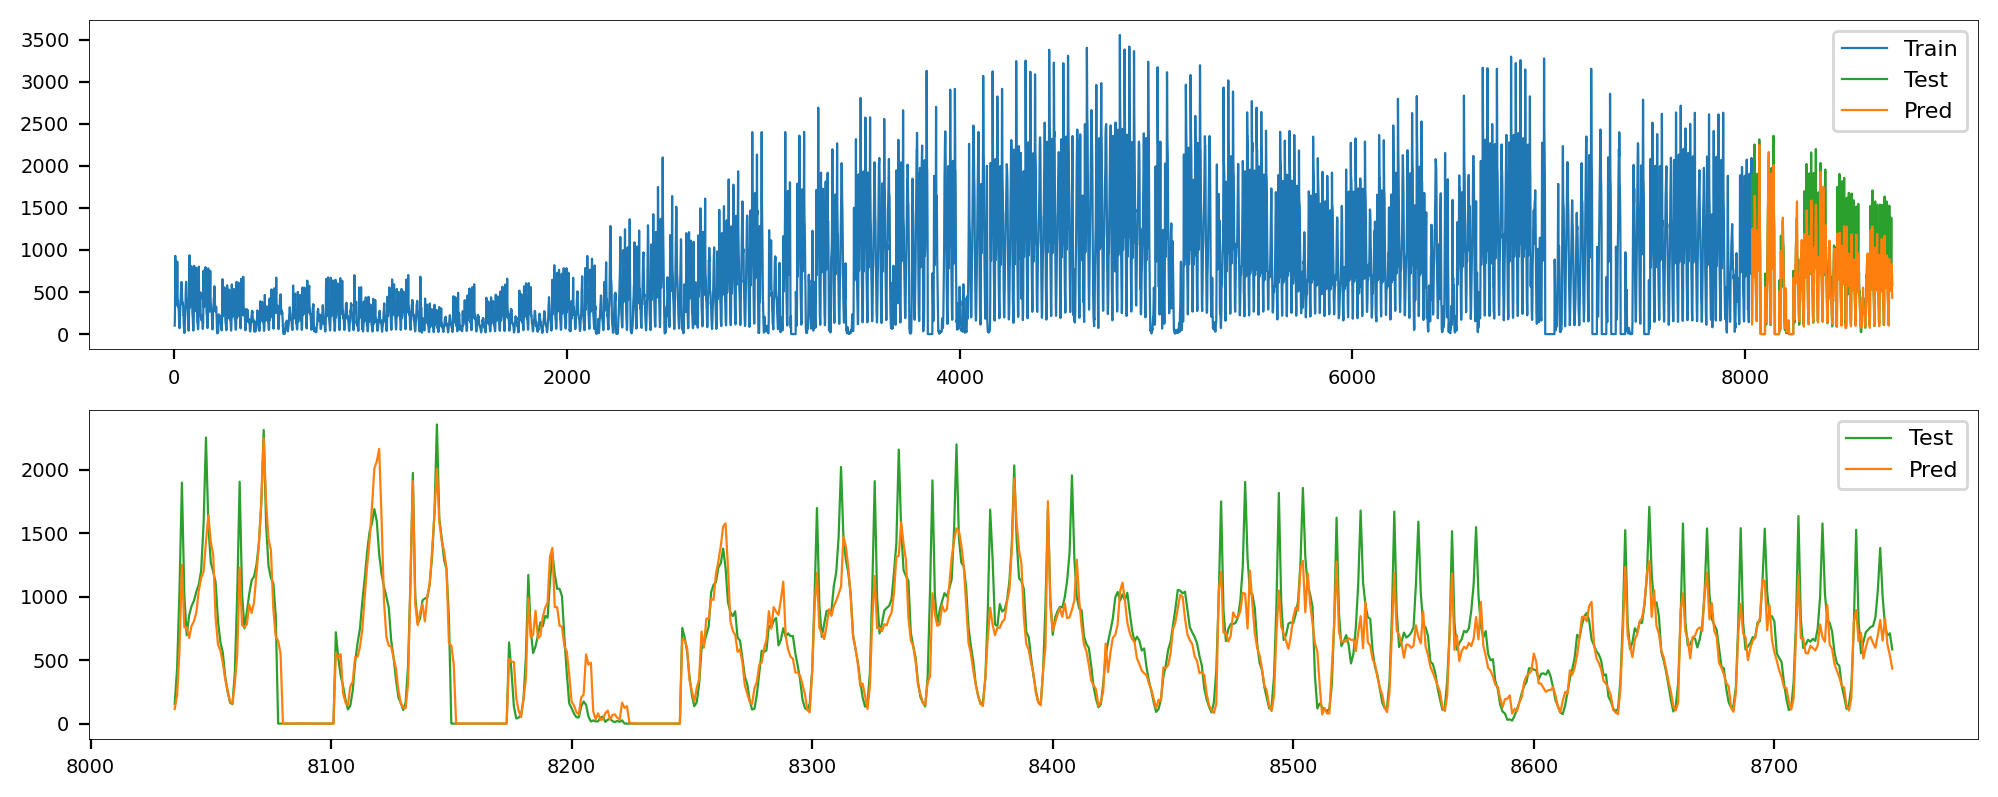

In [120]:
# 예측 결과 시각화
plot_model_result(pd.concat([y_train, y_val]), y_test, y_test_pred)